## **Data Loading**

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import boxcox
import statsmodels.stats as sm_stats
from torch.utils.data import DataLoader
import warnings
import wandb

data, meta = arff.loadarff('MagicTelescope.arff')

df = pd.DataFrame(data)

# --- Normalize column names: strip whitespace, remove special chars, make lowercase ---
df.columns = df.columns.astype(str).str.strip() \
                       .str.replace(r'[^0-9A-Za-z_]', '', regex=True)

df['class'] = df['class'].str.decode('utf-8')

# strip whitespace from string columns
str_cols = df.select_dtypes(include=['object']).columns
for col in str_cols:
    df[col] = df[col].str.strip()

## **Descriptive Statistics**

In [2]:
df.head()

ID   fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  \
0  1.0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   
1  2.0   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   
2  3.0  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580   
3  4.0   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   
4  5.0   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   

   fM3Trans   fAlpha     fDist class  
0   -8.2027  40.0920   81.8828     g  
1   -9.9574   6.3609  205.2610     g  
2  -45.2160  76.9600  256.7880     g  
3   -7.1513  10.4490  116.7370     g  
4   21.8393   4.6480  356.4620     g

In [3]:
df.shape

(19020, 12)

In [4]:
df.describe()

ID       fLength        fWidth         fSize         fConc  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean    9510.500000     53.250154     22.180966      2.825017      0.380327   
std     5490.745396     42.364855     18.346056      0.472599      0.182813   
min        1.000000      4.283500      0.000000      1.941300      0.013100   
25%     4755.750000     24.336000     11.863800      2.477100      0.235800   
50%     9510.500000     37.147700     17.139900      2.739600      0.354150   
75%    14265.250000     70.122175     24.739475      3.101600      0.503700   
max    19020.000000    334.177000    256.382000      5.323300      0.893000   

             fConc1         fAsym       fM3Long      fM3Trans        fAlpha  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean       0.214657     -4.331745     10.545545      0.249726     27.645707   
std        0.110511     59.206062     51.000118     20.827439     26.103621   
min        0.000300   -457.916100   -331.780000   -205.894700      0.000000   
25%        0.128475    -20.586550    -12.842775    -10.849375      5.547925   
50%        0.196500      4.013050     15.314100      0.666200     17.679500   
75%        0.285225     24.063700     35.837800     10.946425     45.883550   
max        0.675200    575.240700    238.321000    179.851000     90.000000   

              fDist  
count  19020.000000  
mean     193.818026  
std       74.731787  
min        1.282600  
25%      142.492250  
50%      191.851450  
75%      240.563825  
max      495.561000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        19020 non-null  float64
 1   fLength   19020 non-null  float64
 2   fWidth    19020 non-null  float64
 3   fSize     19020 non-null  float64
 4   fConc     19020 non-null  float64
 5   fConc1    19020 non-null  float64
 6   fAsym     19020 non-null  float64
 7   fM3Long   19020 non-null  float64
 8   fM3Trans  19020 non-null  float64
 9   fAlpha    19020 non-null  float64
 10  fDist     19020 non-null  float64
 11  class     19020 non-null  object 
dtypes: float64(11), object(1)
memory usage: 1.7+ MB


In [6]:
df.nunique()

ID          19020
fLength     18643
fWidth      18200
fSize        7228
fConc        6410
fConc1       4421
fAsym       18704
fM3Long     18693
fM3Trans    18390
fAlpha      17981
fDist       18437
class           2
dtype: int64

In [7]:
print(df.duplicated().sum())

0


In [8]:
print(df.isna().sum())

ID          0
fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64


In [9]:
# we will do binary classification and thus we need to convert the target variable to 0 and 1
class_mapping = {'g': 1, 'h': 0}
df['class'] = df['class'].map(class_mapping)

# Drop ID column as it is not useful for modeling
df.drop('ID', axis=1, inplace=True)

# Drop duplicates if any
df.drop_duplicates(inplace=True)

df.head()



fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1

In [10]:
df.shape

(18905, 11)

In [11]:
data_all = df[col].dropna()
data_g = df[df['class'] == class_mapping['g']][col].dropna()  # 1 for 'g'
data_h = df[df['class'] == class_mapping['h']][col].dropna()  # 0 for 'h'

In [12]:
numeric_df = df.select_dtypes(include=[np.number])
cols = numeric_df.columns

correlations = []

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col1, col2 = cols[i], cols[j]
        corr_value = np.corrcoef(df[col1], df[col2])[0, 1]
        correlations.append((col1, col2, corr_value))

corr_df = pd.DataFrame(correlations, columns=["Feature 1", "Feature 2", "Correlation"])

corr_df = corr_df.sort_values(by="Correlation", ascending=False)

print("Top 20 najsilnejších korelácií:")
print(corr_df.head(10))
print(corr_df.tail(10))

Top 20 najsilnejších korelácií:
   Feature 1 Feature 2  Correlation
27     fConc    fConc1     0.976455
0    fLength    fWidth     0.770007
10    fWidth     fSize     0.716441
1    fLength     fSize     0.701911
25     fSize     fDist     0.435801
8    fLength     fDist     0.417785
17    fWidth     fDist     0.334571
40     fAsym   fM3Long     0.273706
31     fConc    fAlpha     0.236619
37    fConc1    fAlpha     0.230969
   Feature 1 Feature 2  Correlation
9    fLength     class    -0.308146
32     fConc     fDist    -0.327334
4    fLength     fAsym    -0.365627
53    fAlpha     class    -0.460421
12    fWidth    fConc1    -0.580373
3    fLength    fConc1    -0.597479
11    fWidth     fConc    -0.608862
2    fLength     fConc    -0.630202
20     fSize    fConc1    -0.809135
19     fSize     fConc    -0.850951


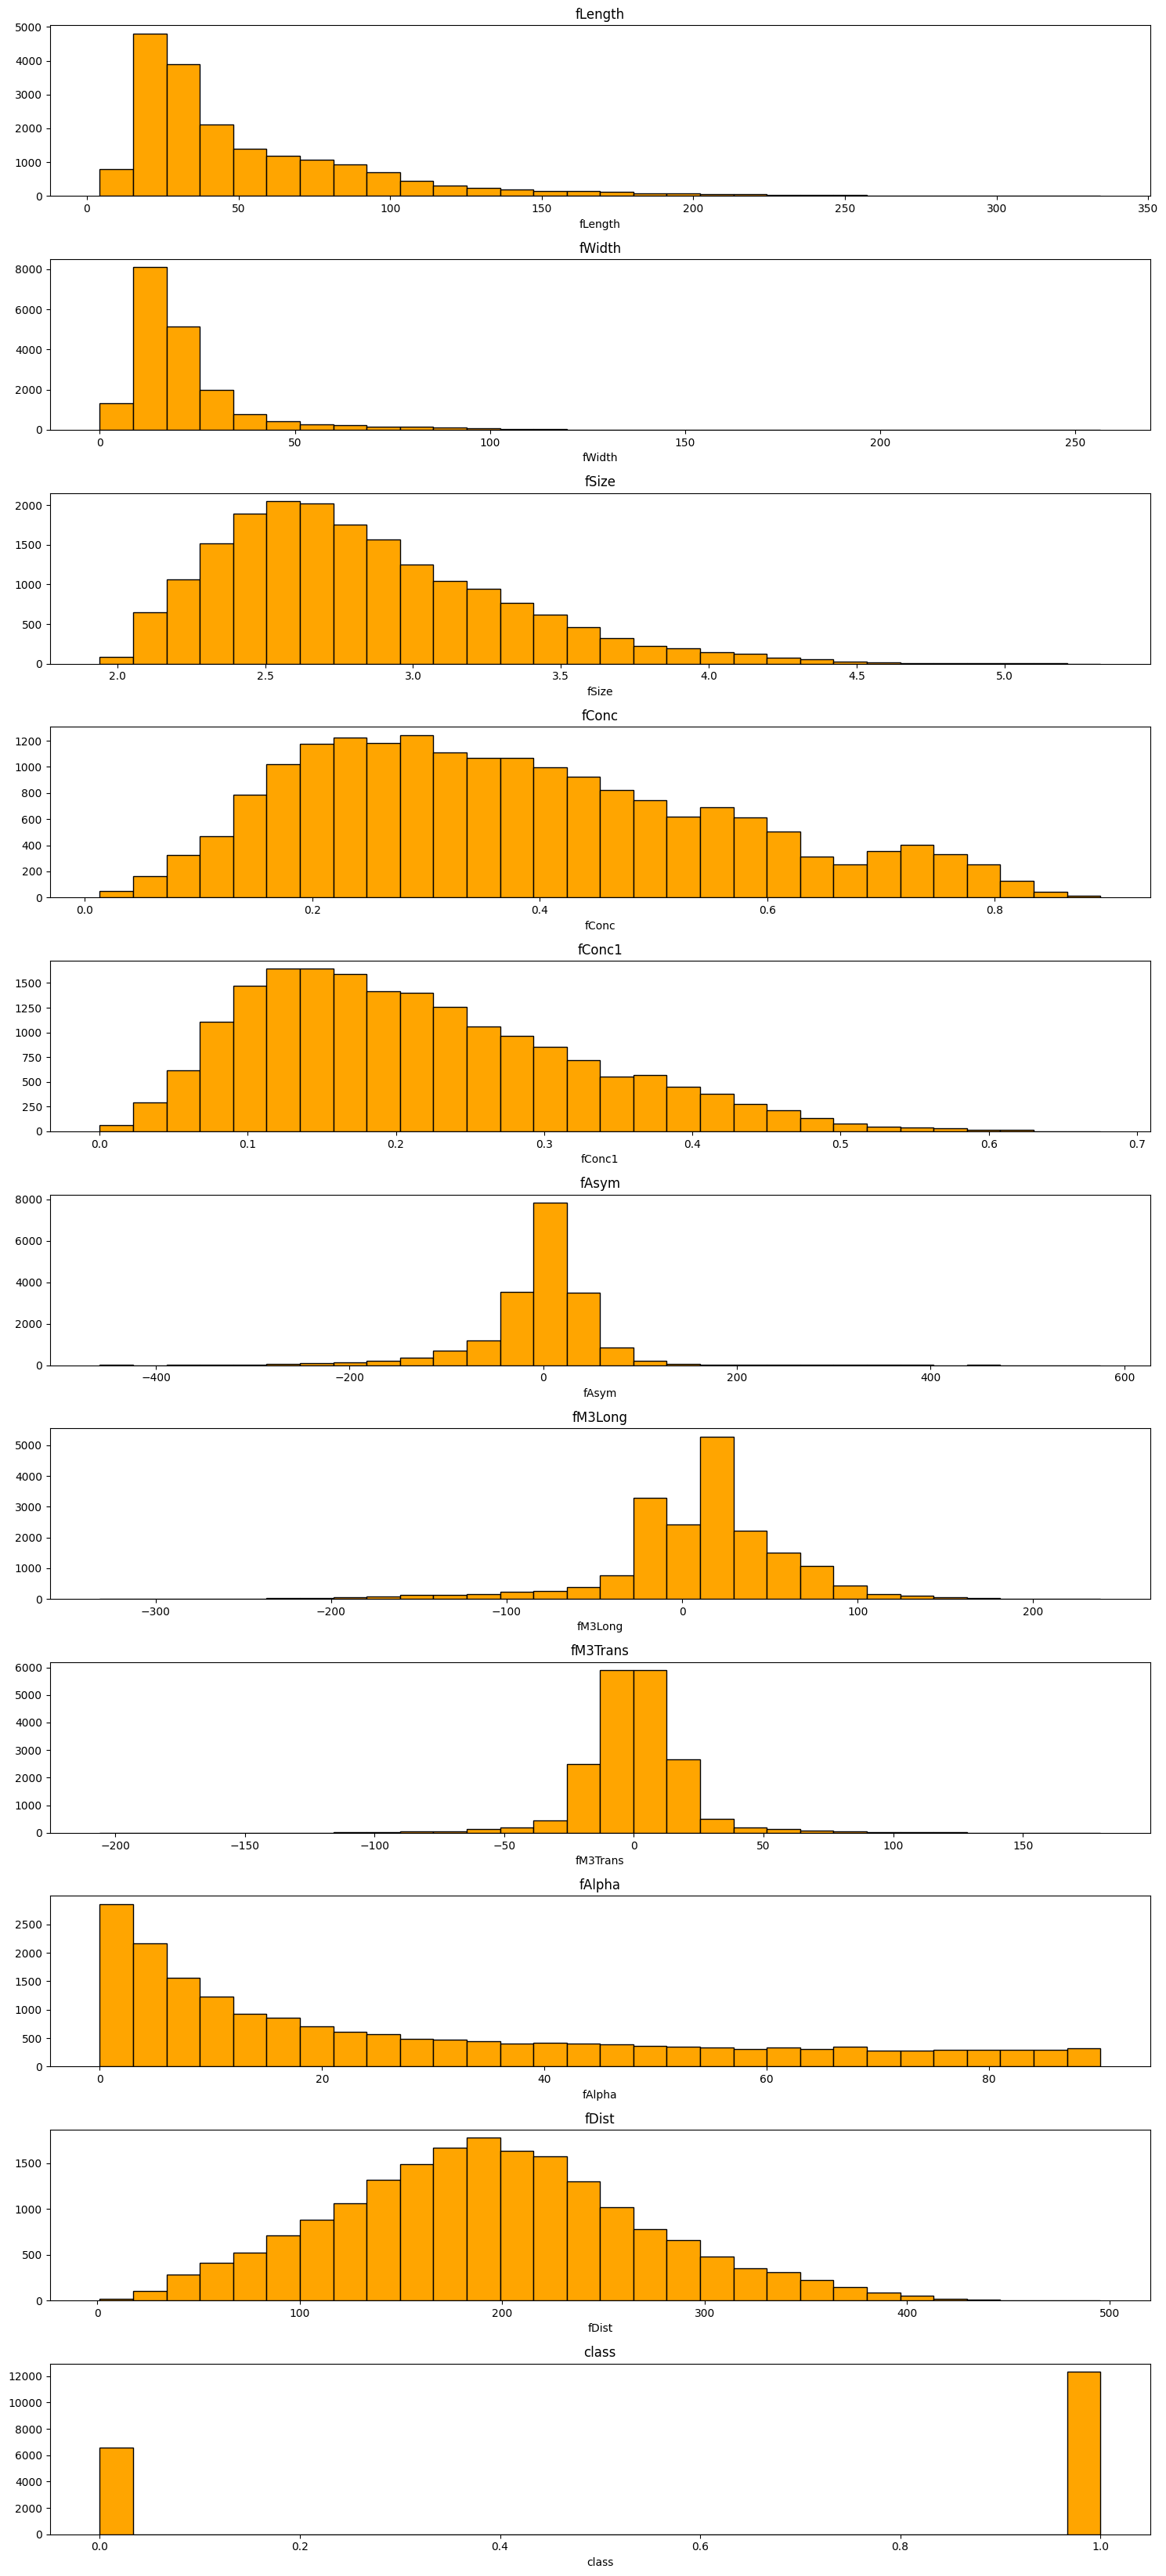

In [13]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.hist(df[col].dropna(), bins=30, color = "orange", edgecolor='black')
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

## **Outlier Detection and Handling**

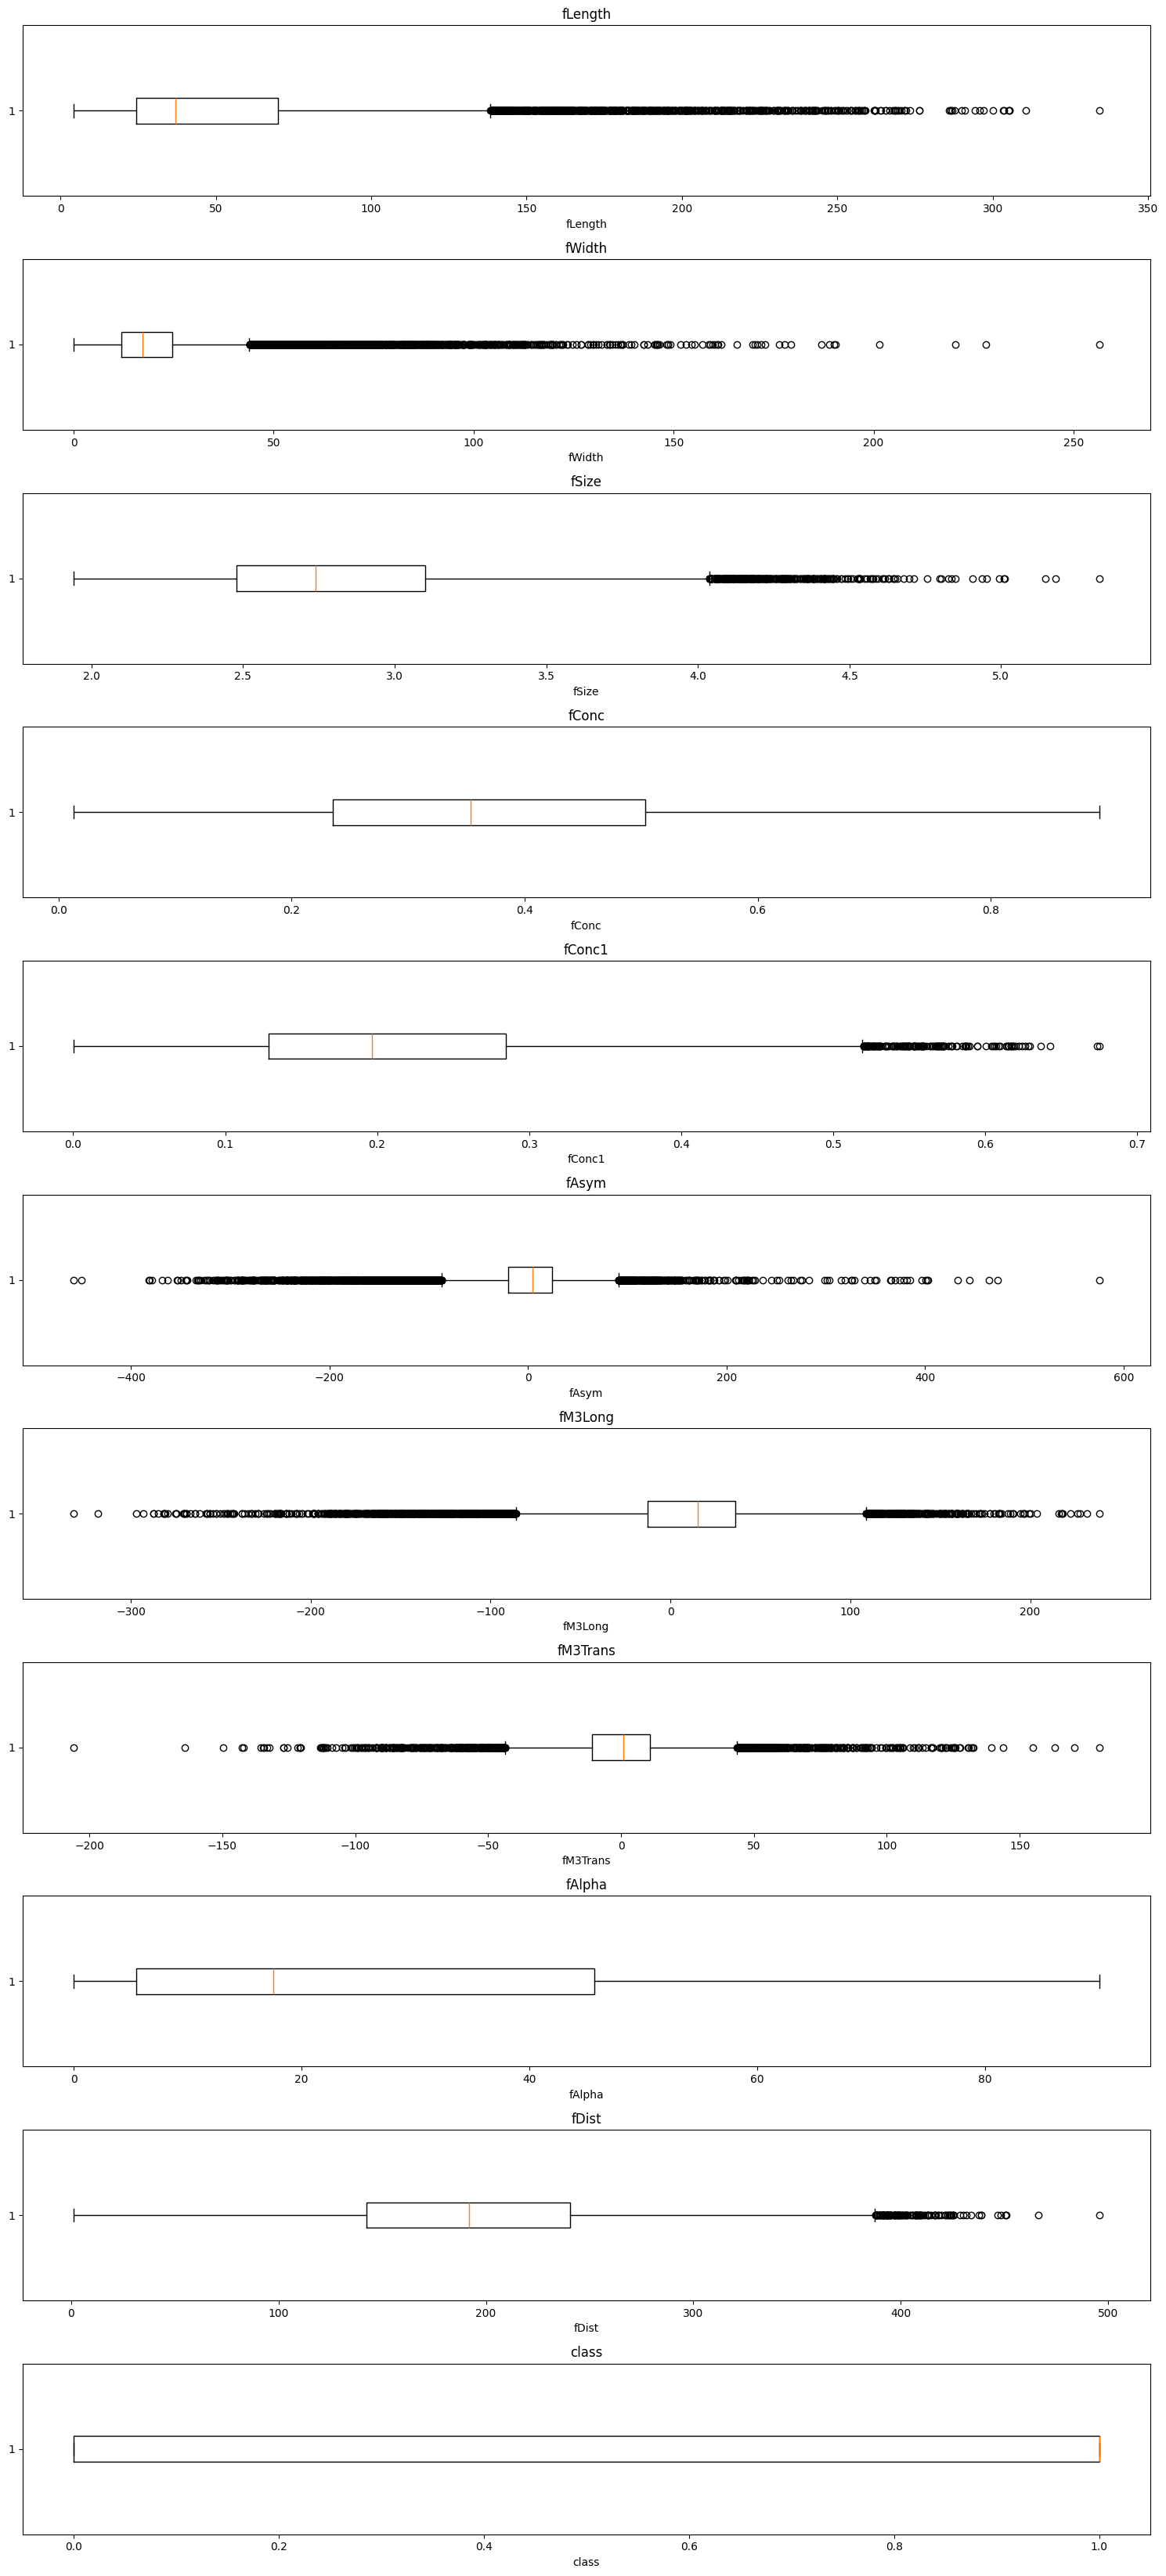

In [14]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [15]:
sample_df = df.sample(n=500, random_state=42)

numeric_df = sample_df.select_dtypes(include=[np.number])

for col in numeric_df.columns:
    stat, p = shapiro(numeric_df[col])
    print(f"{col}: p-value = {p}")

numeric_df = df.select_dtypes(include=[np.number])

fLength: p-value = 1.858069872245337e-24
fWidth: p-value = 3.704576838319469e-27
fSize: p-value = 1.1984217721237743e-09
fConc: p-value = 8.802263817068824e-09
fConc1: p-value = 1.9918905086864378e-10
fAsym: p-value = 2.215824926656684e-20
fM3Long: p-value = 1.3468207372995232e-14
fM3Trans: p-value = 8.343190248258762e-18
fAlpha: p-value = 1.1170179081105686e-19
fDist: p-value = 0.2615154626683263
class: p-value = 3.337070650317777e-32


We loaded the MagicTelescope.arff dataset and converted it into a convenient pandas DataFrame format.
Then we decoded the categorical column class.
We conducted an initial data analysis by examining the structure (df.info()), size (df.shape), and descriptive statistics (df.describe()).
We also checked the number of unique values, duplicates, and missing data — none were found, indicating good data quality.
Then, we have determined that the dataset contains 19,020 observations, 11 numerical features, and 1 categorical feature, making it ready for further analysis and modeling.

In [16]:
outliers_count = {}

for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    count = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)][col].count()
    outliers_count[col] = count

outliers_df = pd.DataFrame(list(outliers_count.items()), columns=['Column', 'Outliers_Count'])
outliers_df = outliers_df.sort_values(by='Outliers_Count', ascending=False)

print(outliers_df)

      Column  Outliers_Count
5      fAsym            1764
1     fWidth            1528
6    fM3Long            1201
0    fLength             963
7   fM3Trans             837
2      fSize             368
4     fConc1             152
9      fDist             126
3      fConc               0
8     fAlpha               0
10     class               0


In [17]:
# Apply Box-Cox transformation to columns with high outlier counts to reduce skewness and outliers
# Box-Cox requires positive values; shift if necessary

columns_to_transform = ['fAsym', 'fWidth', 'fM3Long', 'fLength', 'fM3Trans', 'fConc1', 'fDist', 'fSize']

for col in columns_to_transform:
    if col in df.columns and df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        if (df[col] <= 0).any():
            shift = 1 - df[col].min()  # Shift to make all positive
            df[col] = df[col] + shift
        df[col], _ = boxcox(df[col])
        print(f"Box-Cox applied to {col}")

# Note: 'ID', 'fConc', 'fAlpha', 'class' have no outliers or are not numeric/transformable

Box-Cox applied to fAsym
Box-Cox applied to fWidth
Box-Cox applied to fM3Long
Box-Cox applied to fLength
Box-Cox applied to fM3Trans
Box-Cox applied to fConc1
Box-Cox applied to fDist
Box-Cox applied to fSize


In [18]:
# Alternative: Drop outliers instead of transforming
# Identify and drop rows where any of the outlier-prone columns have outliers (using IQR method)

# columns_with_outliers = ['fAsym', 'fWidth', 'fM3Long', 'fLength', 'fM3Trans', 'fConc1', 'fDist', 'fSize']

# # Create a mask to keep rows without outliers in any of these columns
# mask = pd.Series([True] * len(df), index=df.index)

# for col in columns_with_outliers:
#     if col in df.columns and df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)

# # Drop rows with outliers
# df = df[mask]

# print(f"Rows after dropping outliers: {len(df)}")
# print(f"Rows dropped: {len(mask) - len(df)}")

# Note: This removes rows where any of the specified columns have outliers. Adjust the list or logic if needed.
# After dropping, you can proceed with visualization or modeling.

In [19]:
# print(df['class'].value_counts())  # Omitted as per request

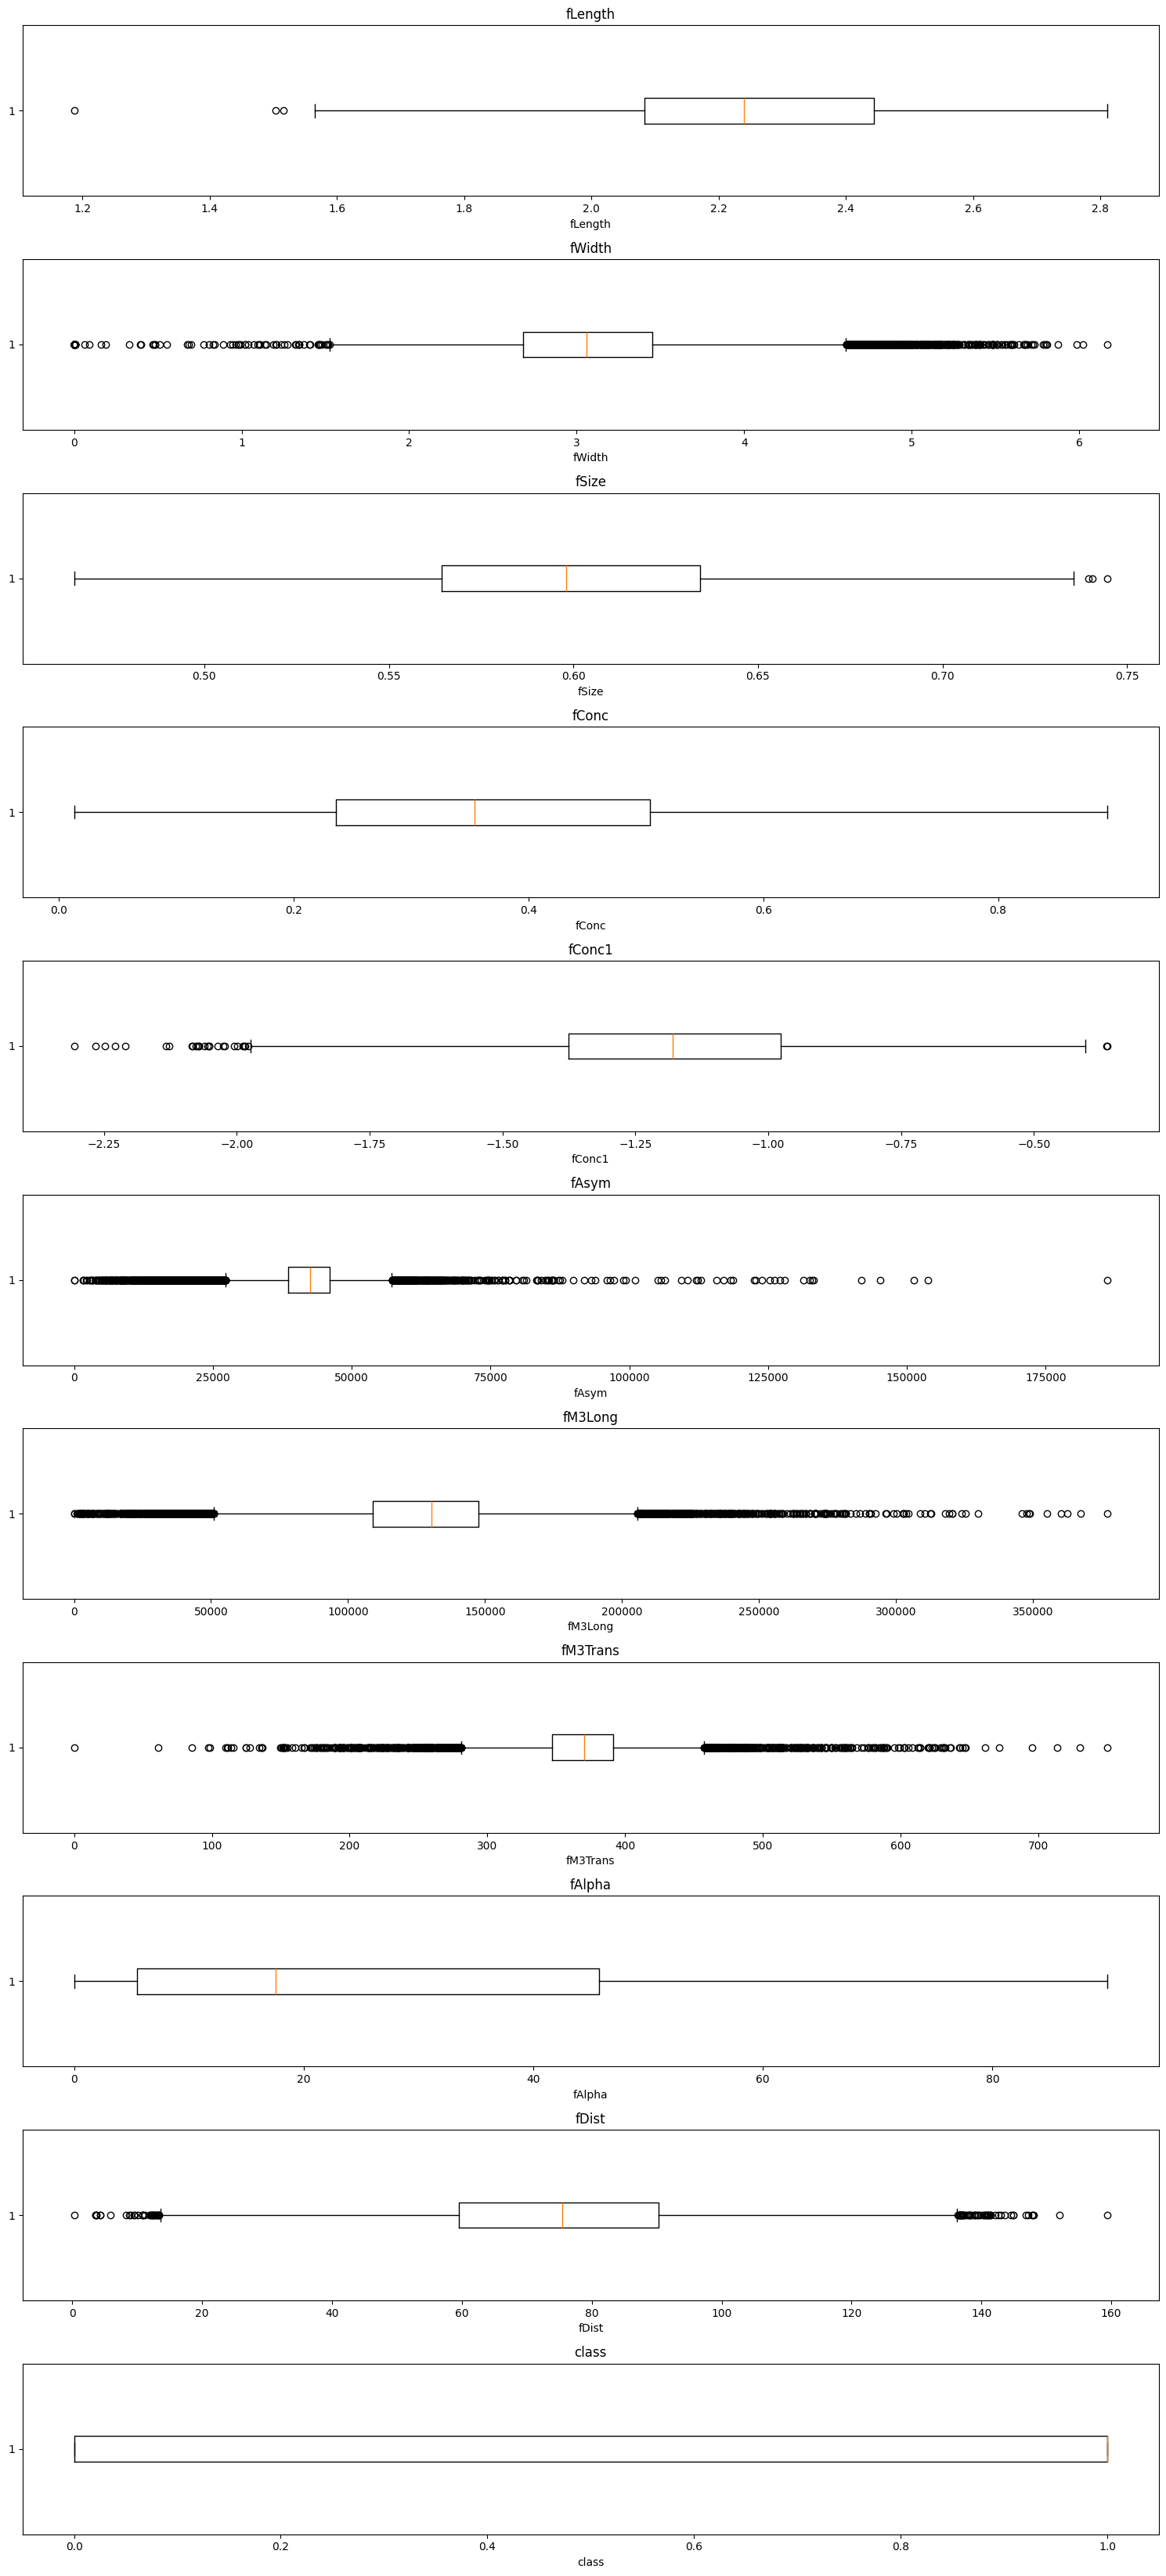

In [20]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

## **Pairwise Correlation Matrix**

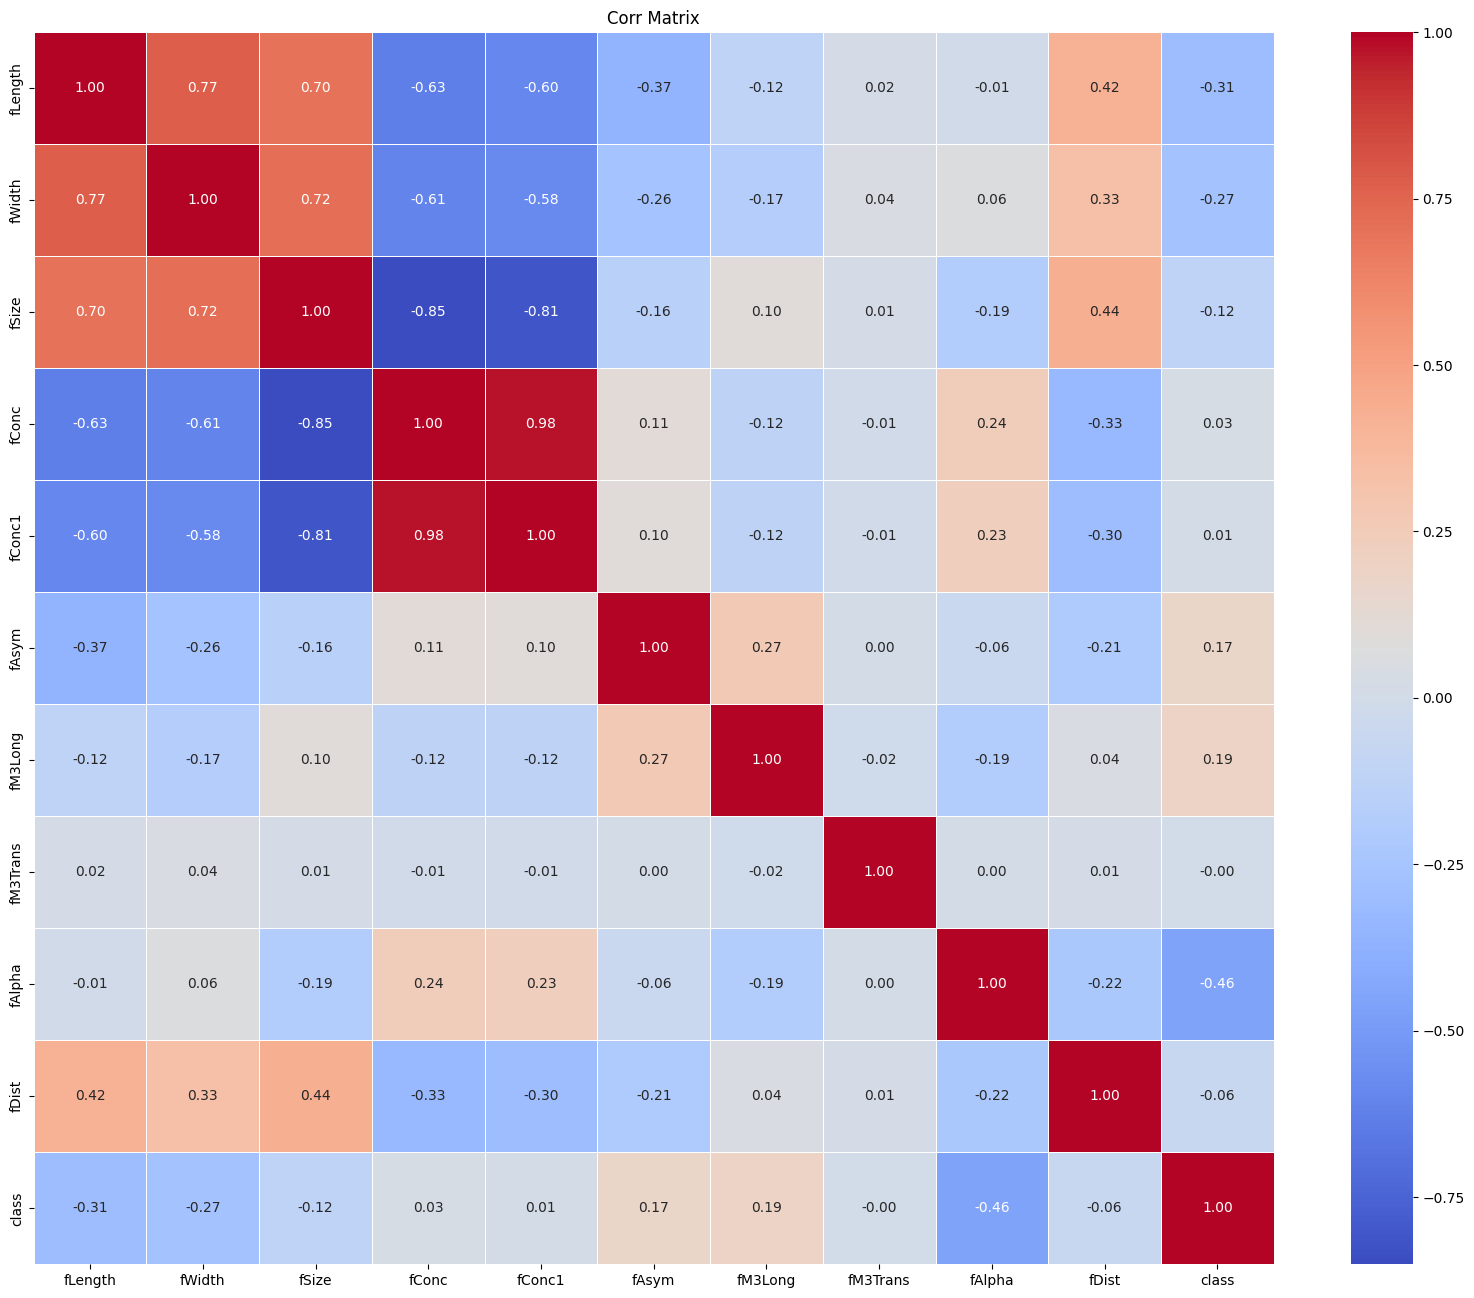

In [21]:
relationships_matrix = numeric_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(relationships_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Corr Matrix')
plt.show()

In [22]:
numeric_df = df.select_dtypes(include=[np.number])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18905 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   18905 non-null  float64
 1   fWidth    18905 non-null  float64
 2   fSize     18905 non-null  float64
 3   fConc     18905 non-null  float64
 4   fConc1    18905 non-null  float64
 5   fAsym     18905 non-null  float64
 6   fM3Long   18905 non-null  float64
 7   fM3Trans  18905 non-null  float64
 8   fAlpha    18905 non-null  float64
 9   fDist     18905 non-null  float64
 10  class     18905 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.7 MB


In [23]:
# Calculate correlations with 'class'
correlations_abs = numeric_df.corr()['class'].abs().sort_values(ascending=False)
correlations_signed = numeric_df.corr()['class'][correlations_abs.index]

result_df = pd.DataFrame({
    'Feature': correlations_abs.index,
    'Abs Correlation': correlations_abs.values,
    'Signed Correlation': correlations_signed.values
})

print("Strongest correlations with 'class' (ordered by absolute value):")
print(result_df.to_string(index=False))

Strongest correlations with 'class' (ordered by absolute value):
 Feature  Abs Correlation  Signed Correlation
   class         1.000000            1.000000
  fAlpha         0.460421           -0.460421
 fLength         0.205256           -0.205256
  fWidth         0.161498           -0.161498
 fM3Long         0.142751            0.142751
   fAsym         0.138239            0.138239
   fSize         0.127888           -0.127888
   fDist         0.057214           -0.057214
  fConc1         0.029324            0.029324
   fConc         0.025442            0.025442
fM3Trans         0.009878           -0.009878


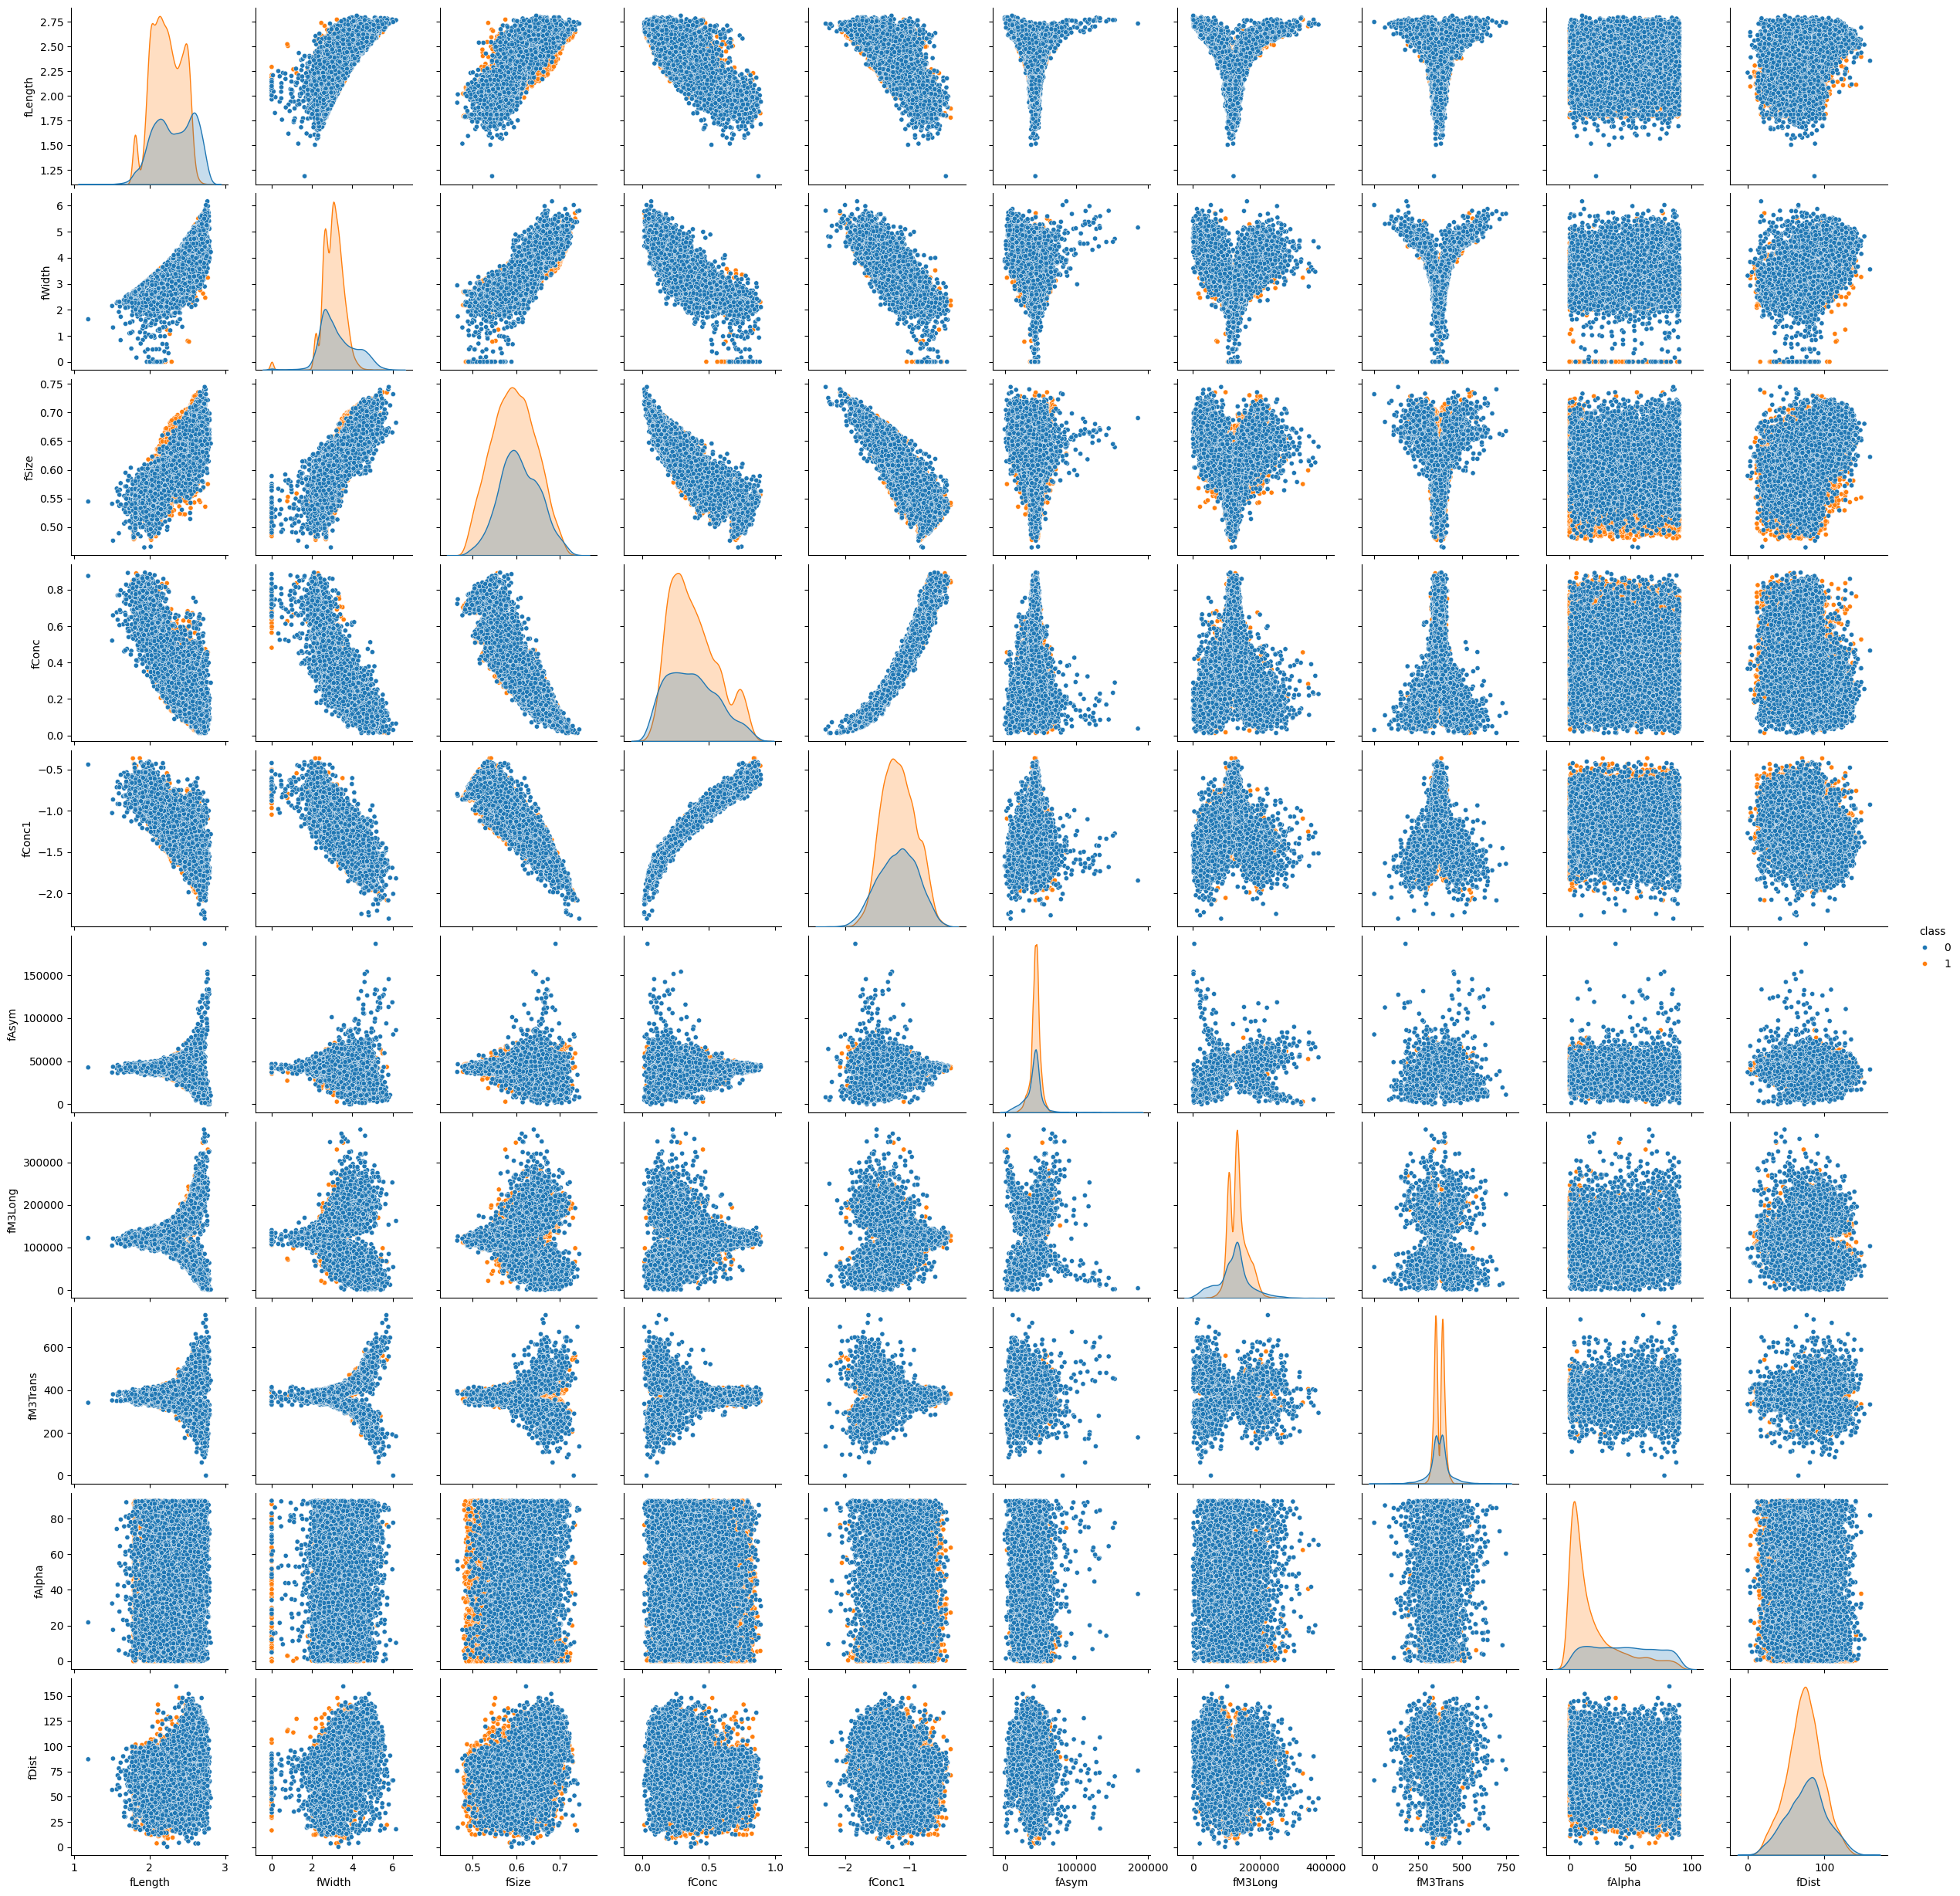

In [24]:
sns.pairplot(
    df,
    corner=False,
    plot_kws={'alpha': 1.0, 's': 20},
    hue='class',  # Pridanie farebného rozlíšenia podľa 'oximetry'
)

We analyzed the distributions of all numerical features and detected potential outliers.
To reduce skewness and handle extreme values, we applied the Box-Cox transformation to several columns.
This helped normalize the data and improve its statistical properties.
After cleaning and transforming the data, we constructed a correlation matrix to explore relationships between features.
This allowed us to identify the strongest positive and negative correlations in the dataset.

In [25]:
# Helper function: Cohen's d effect size
def cohend(d1, d2):
    """
    Calculate Cohen's d for independent samples.
    d1, d2: array-like data for two groups
    Returns: Cohen's d value (standardized mean difference)
    """
    from numpy import var, sqrt, mean
    
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    
    # calculate the effect size
    return (u1 - u2) / s

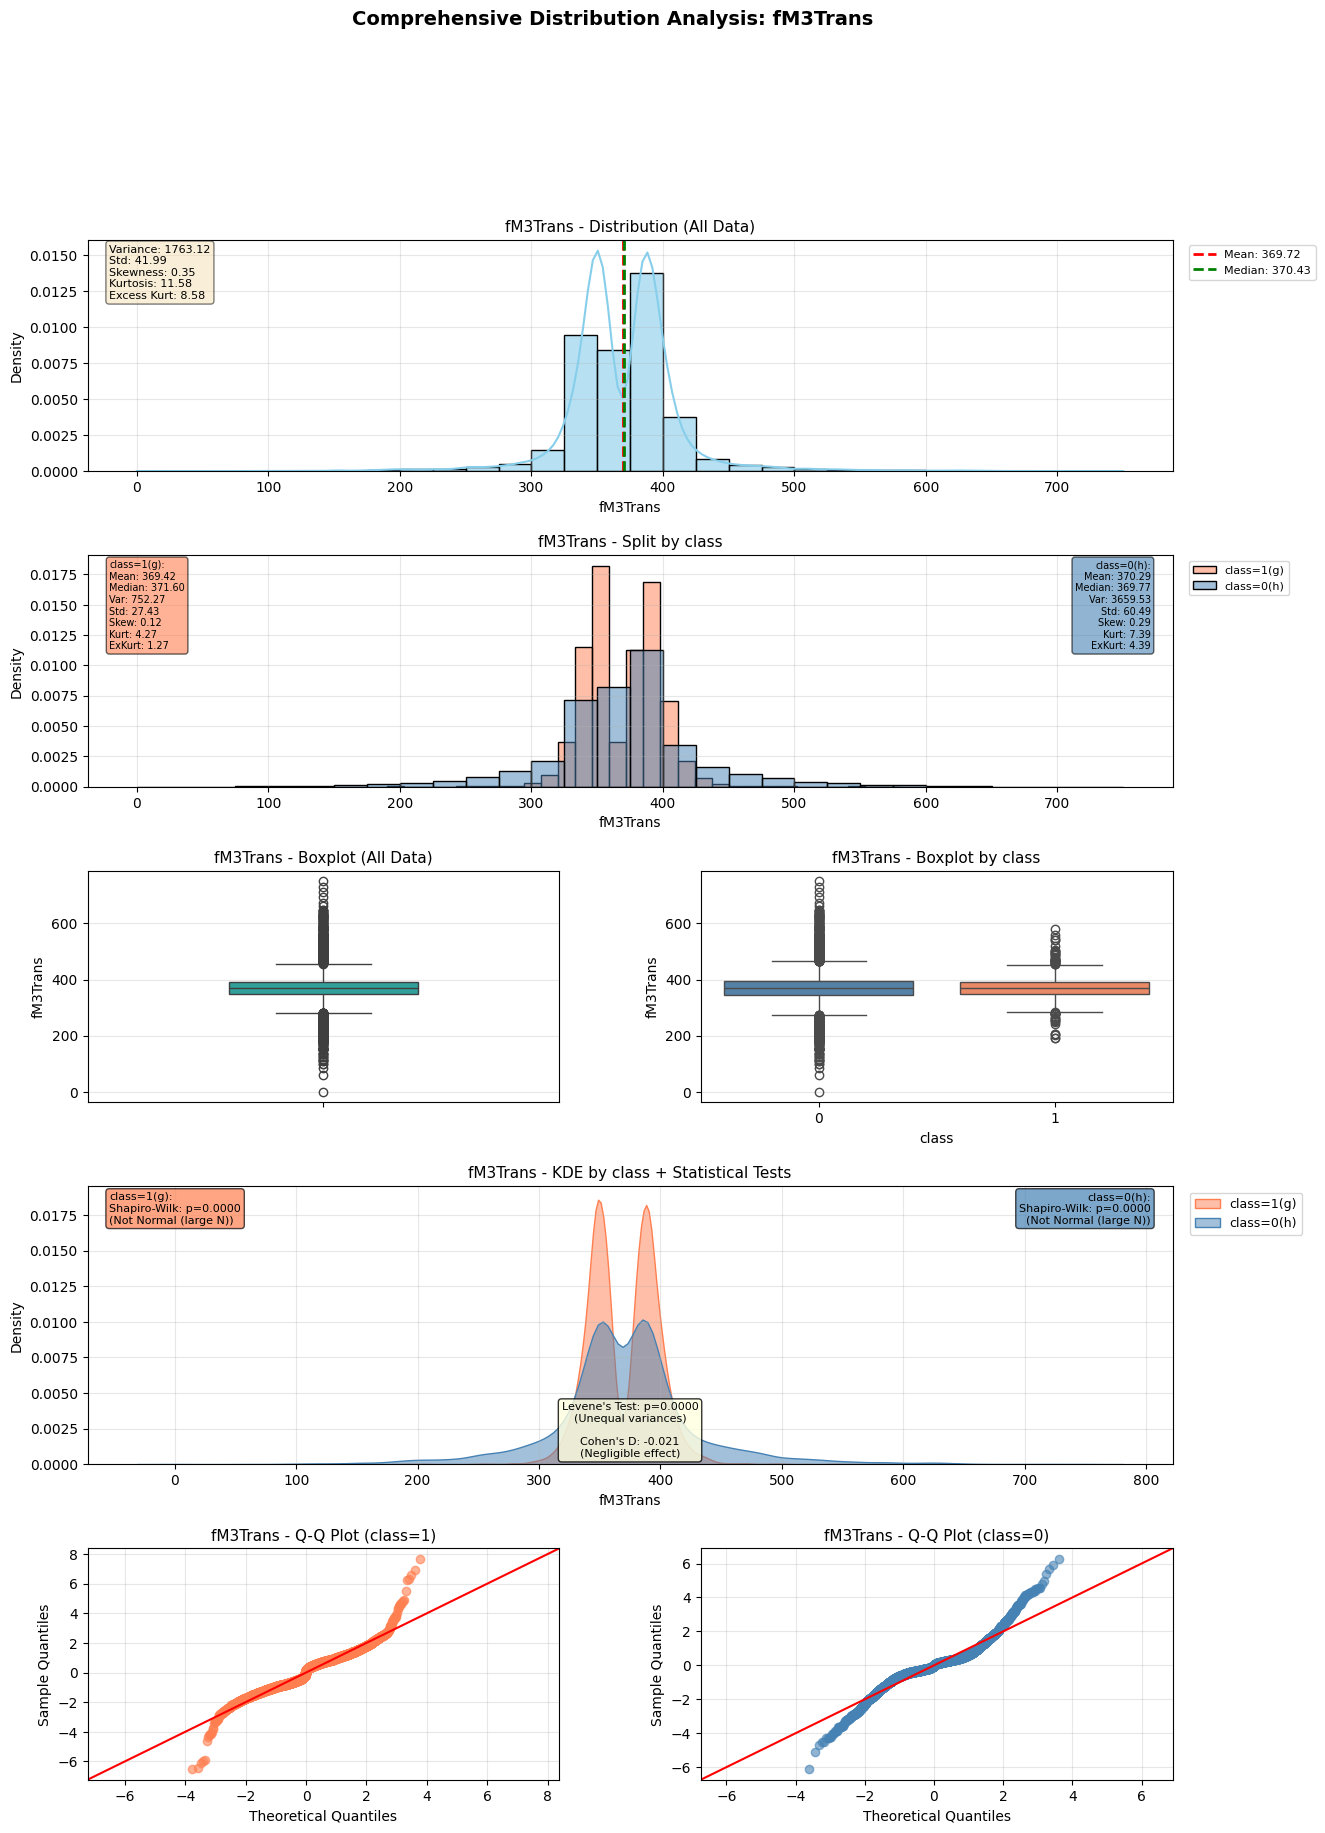

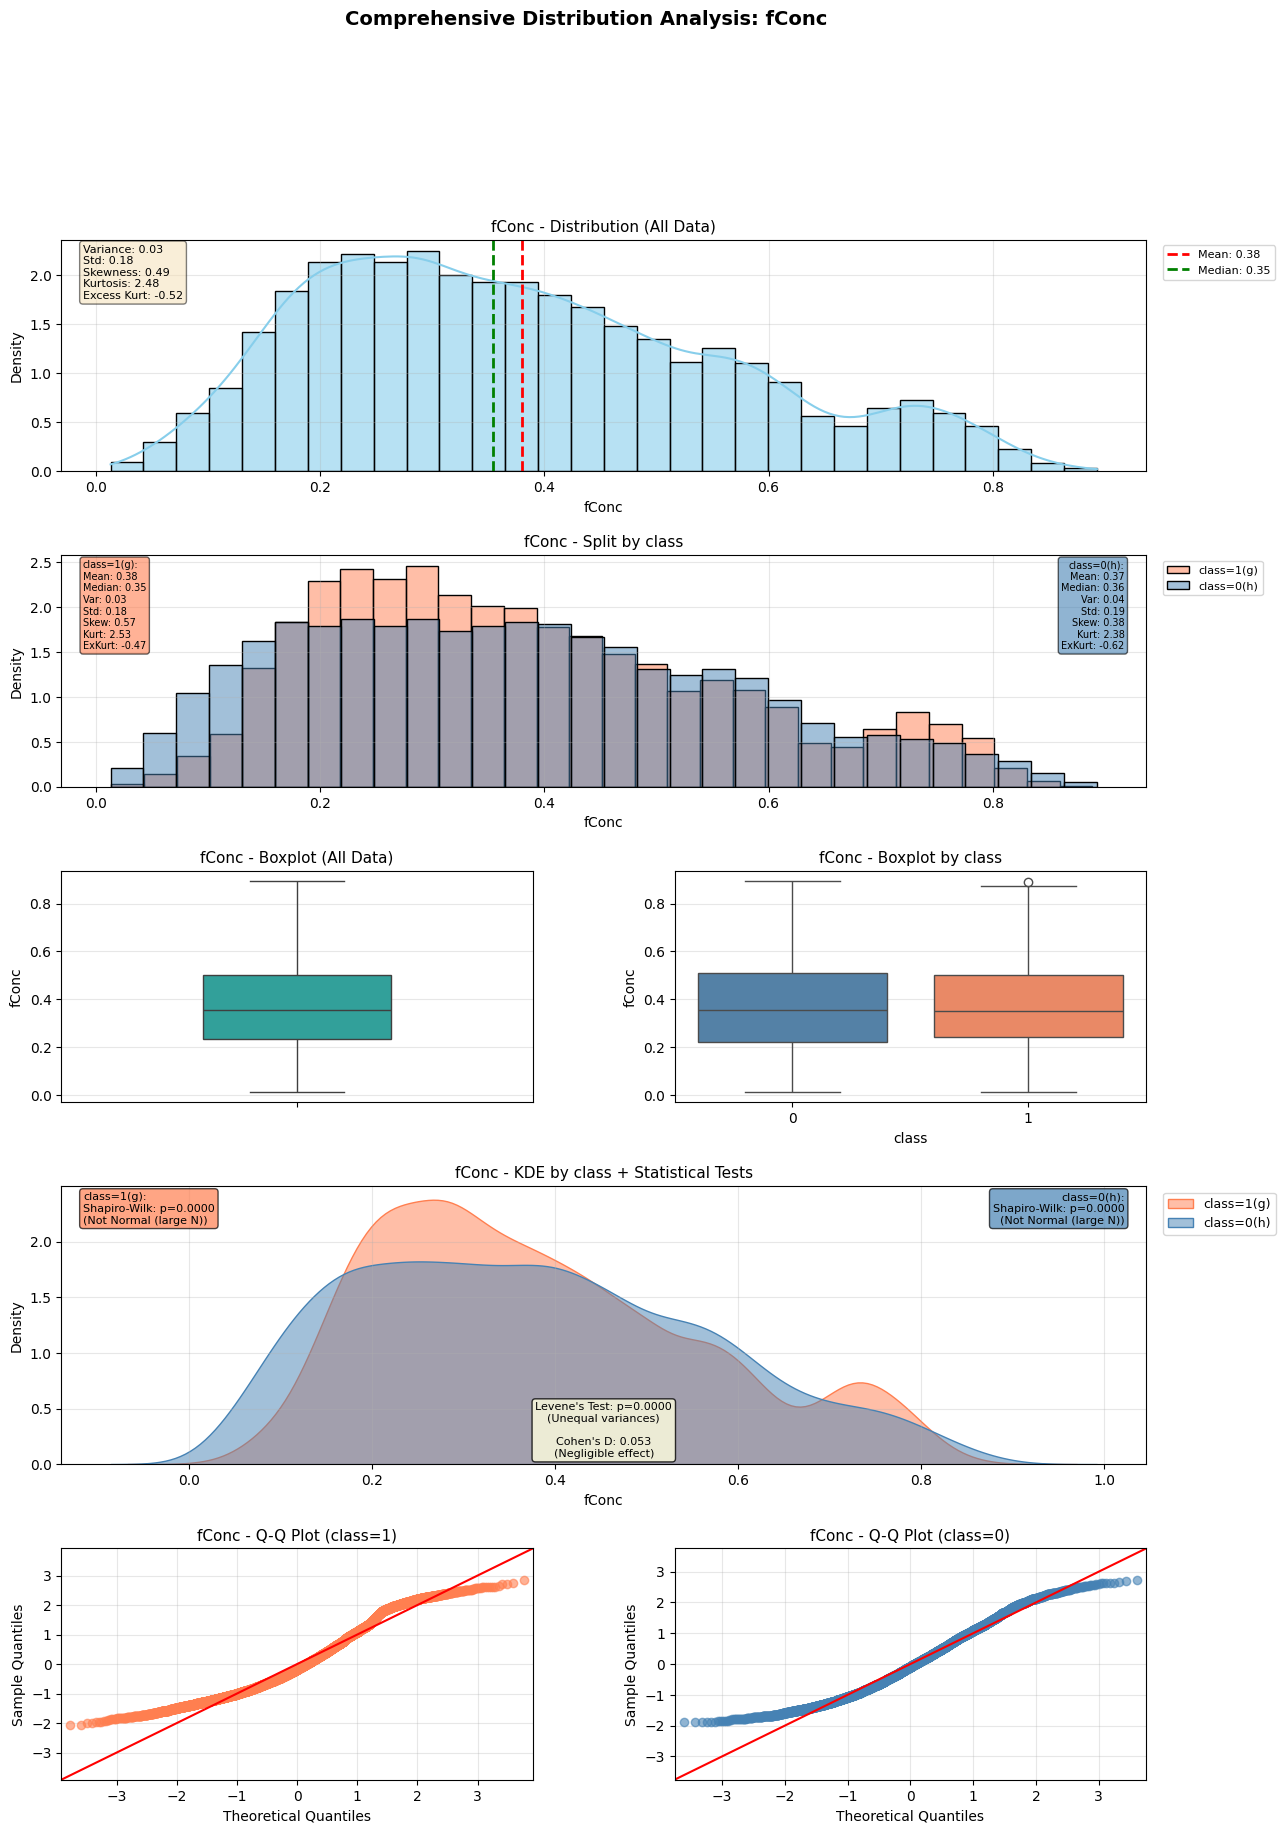

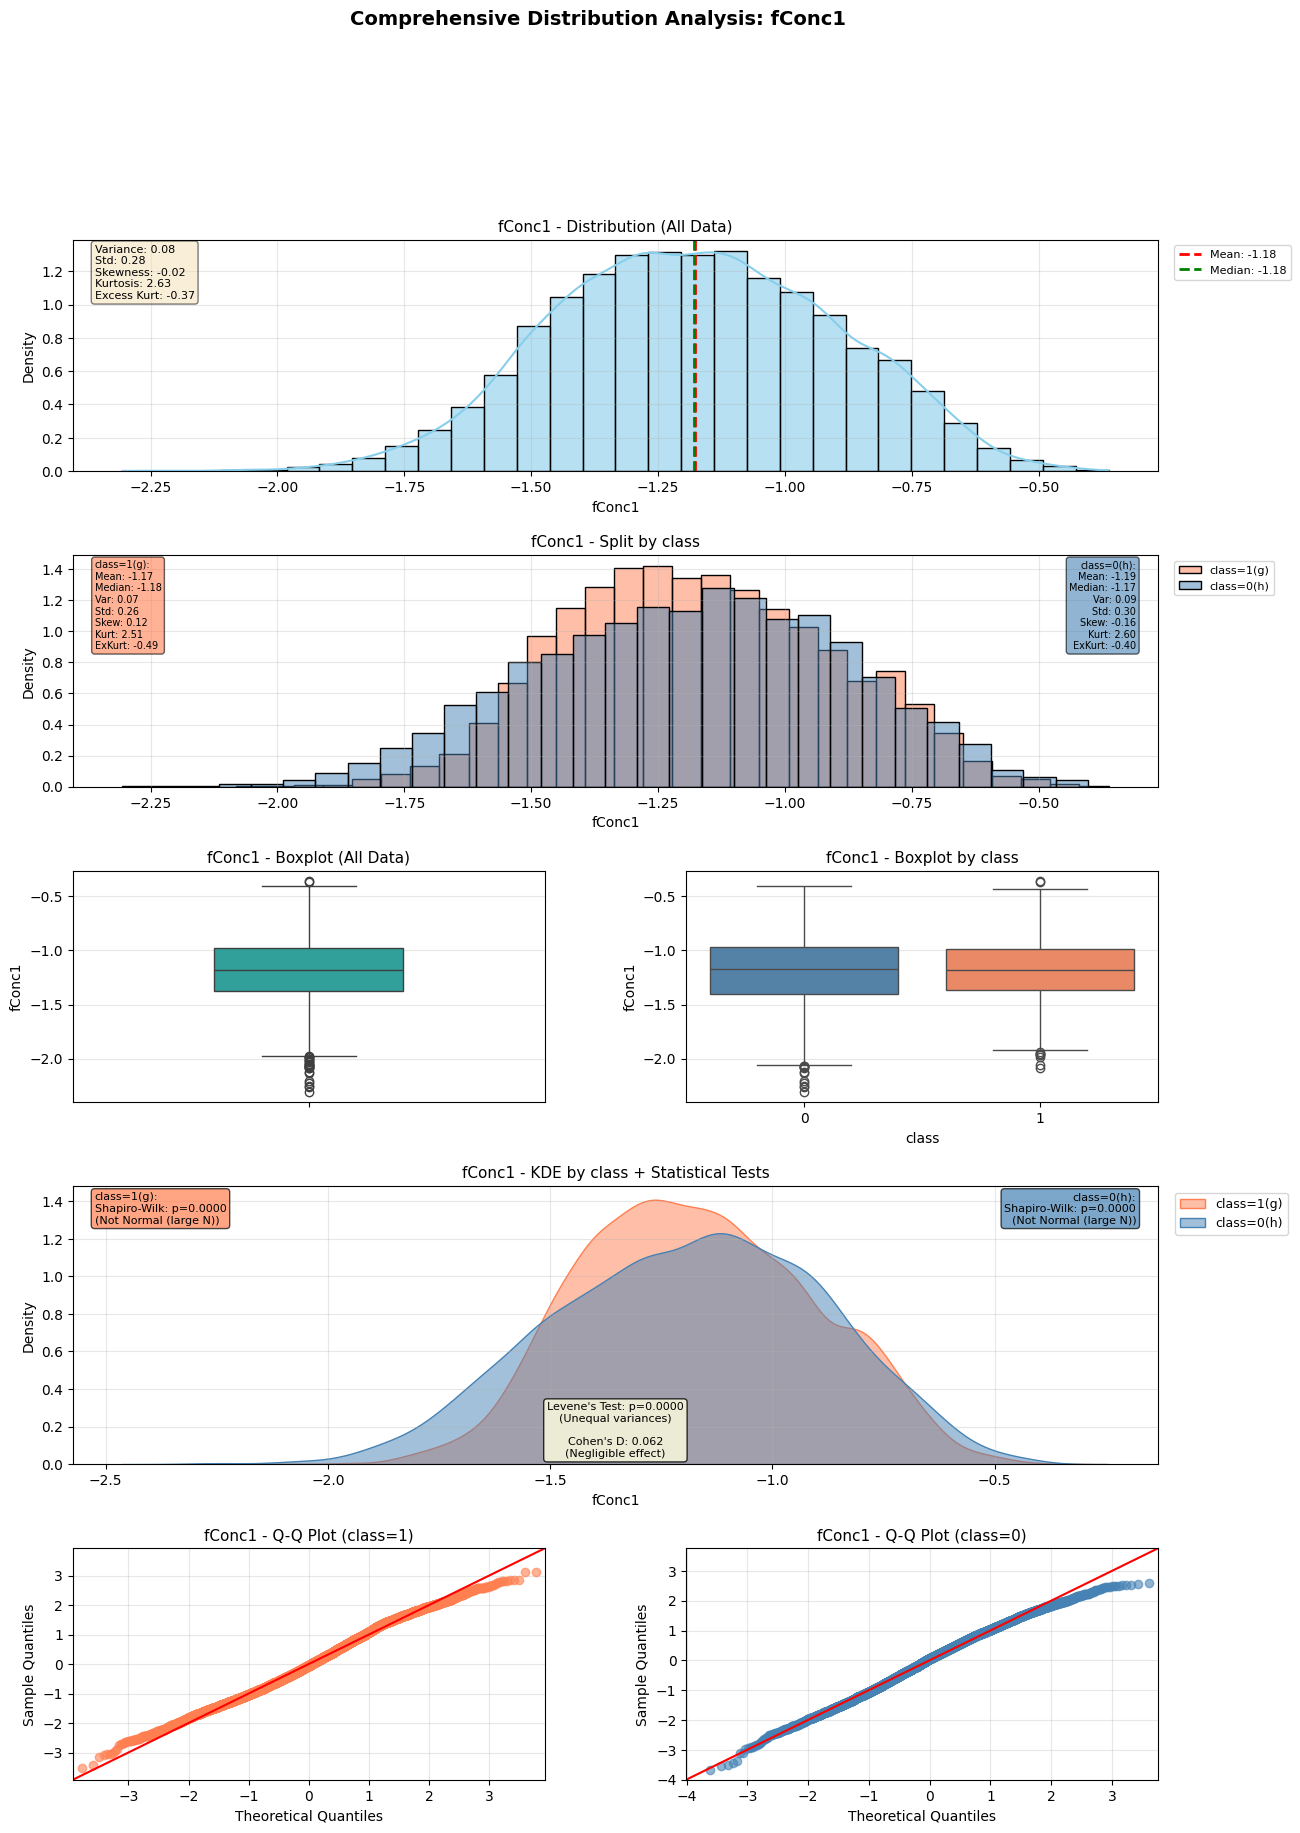

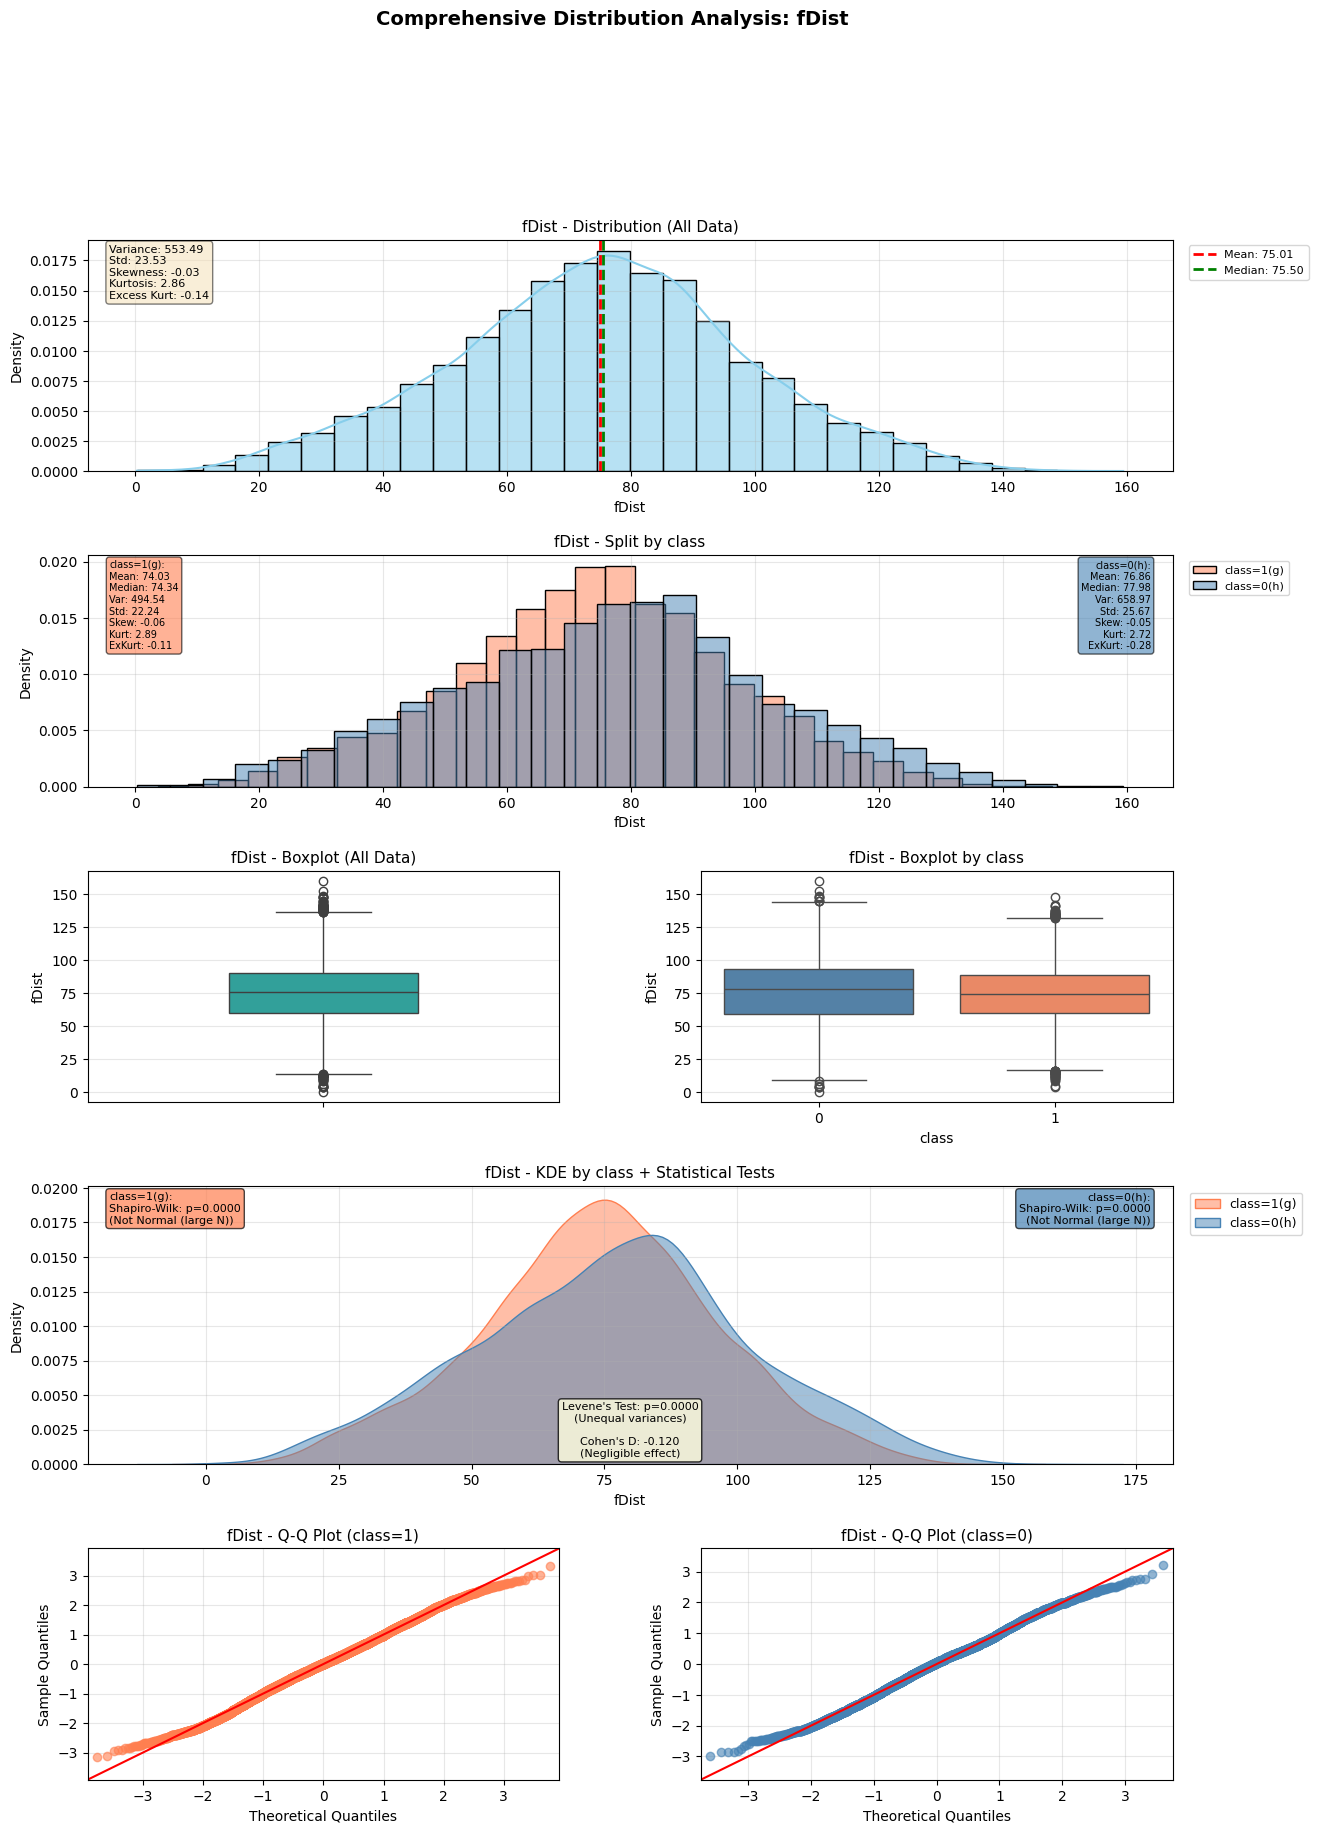

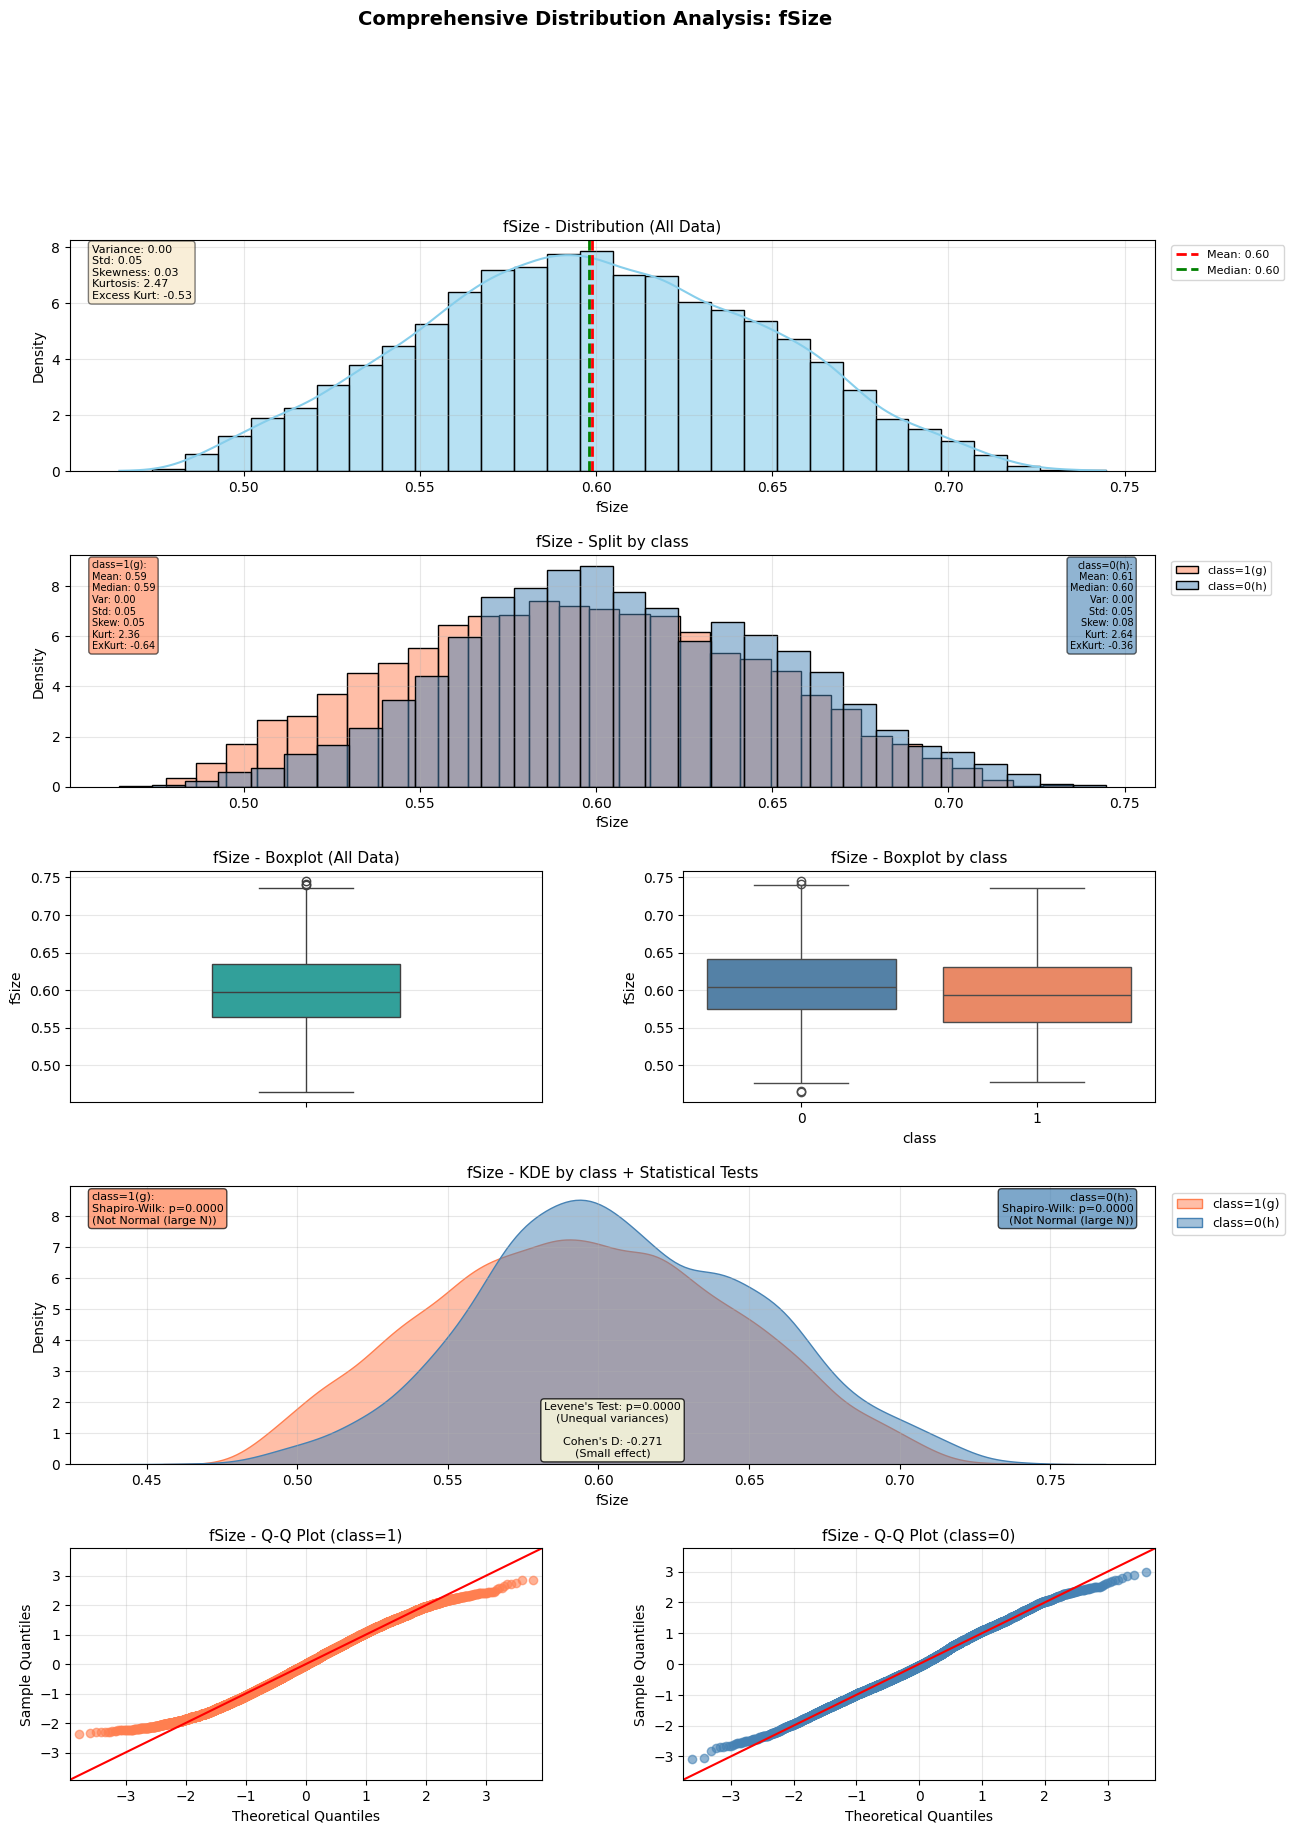

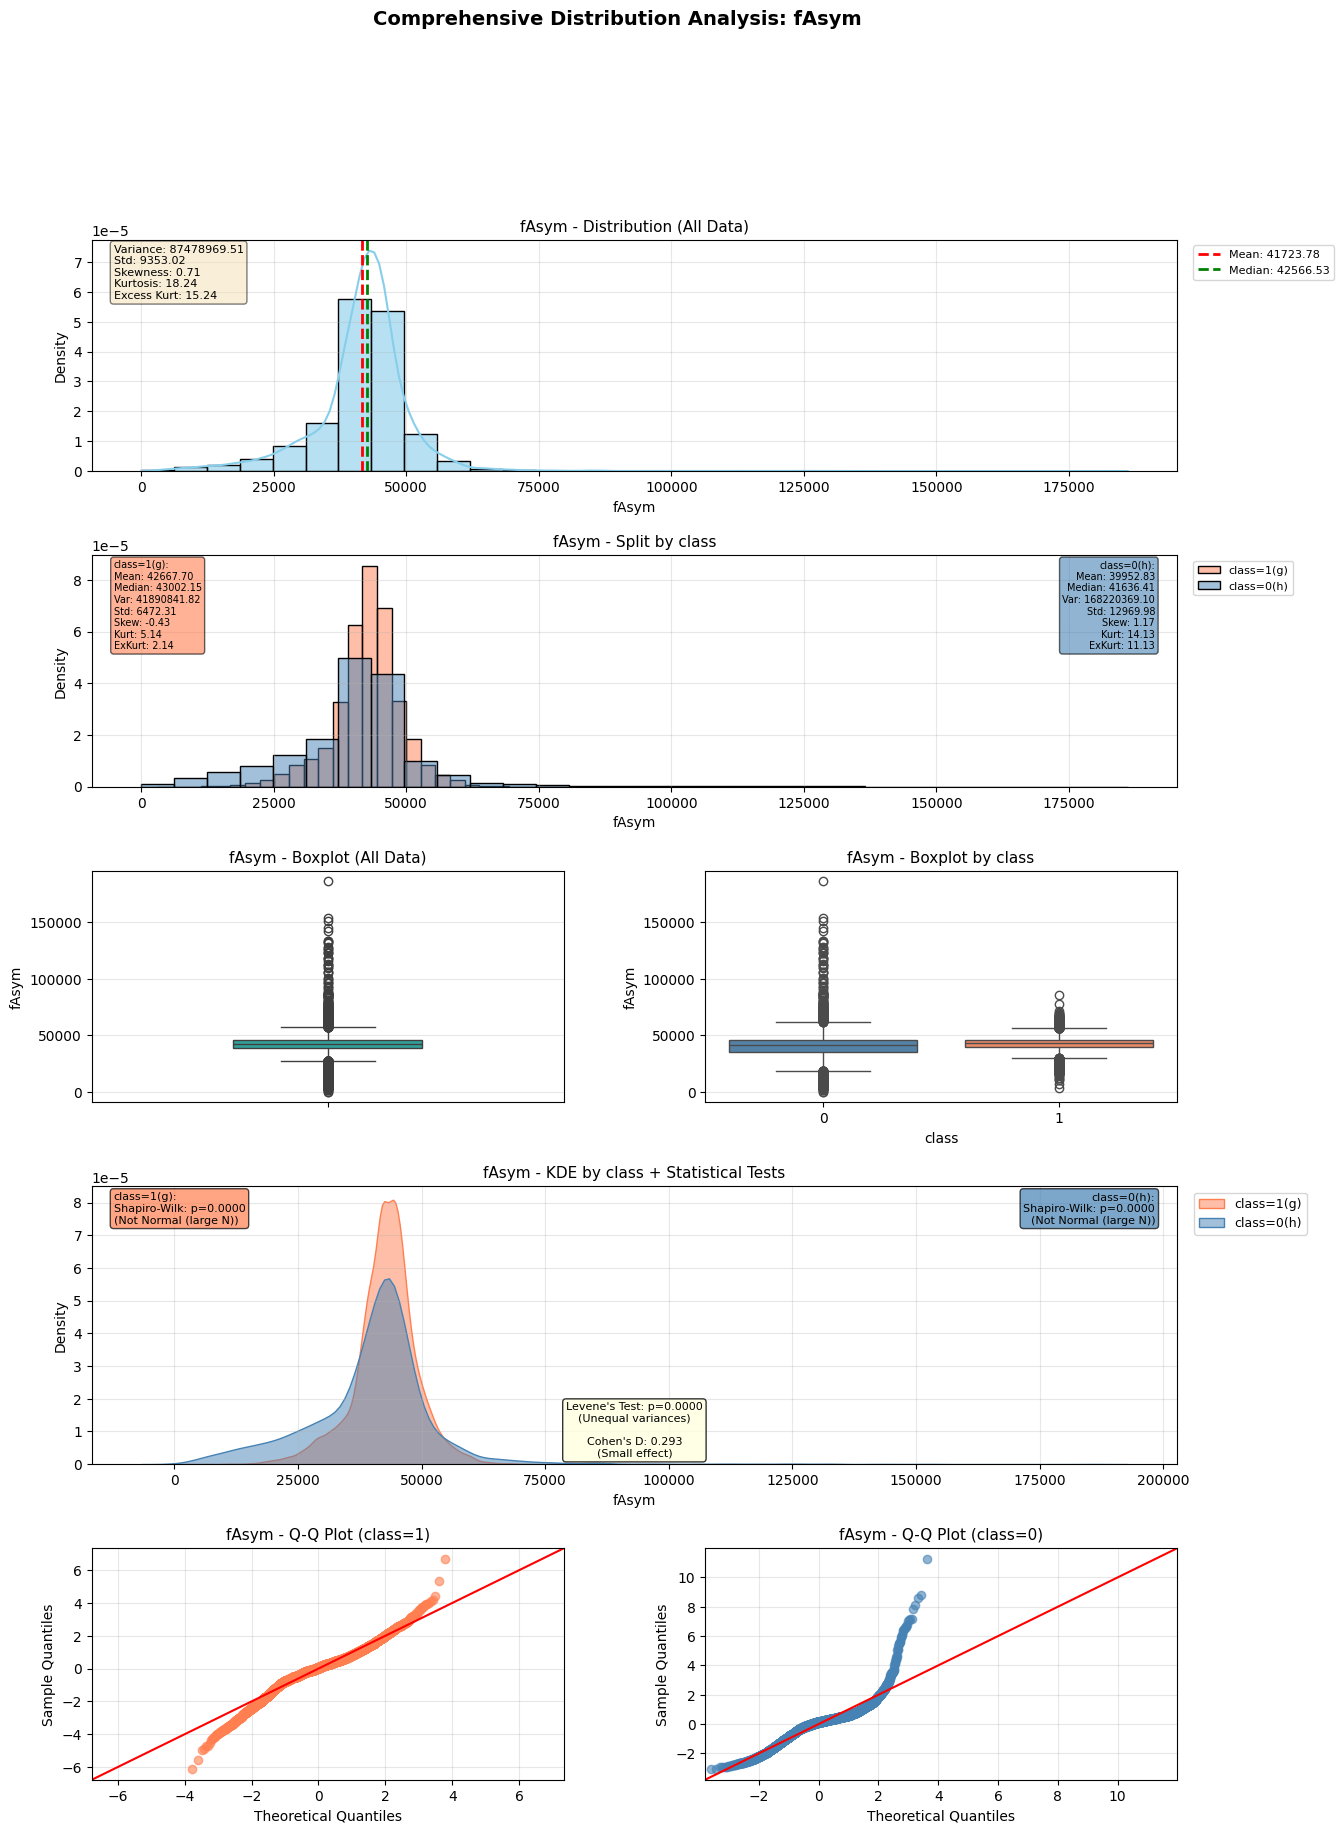

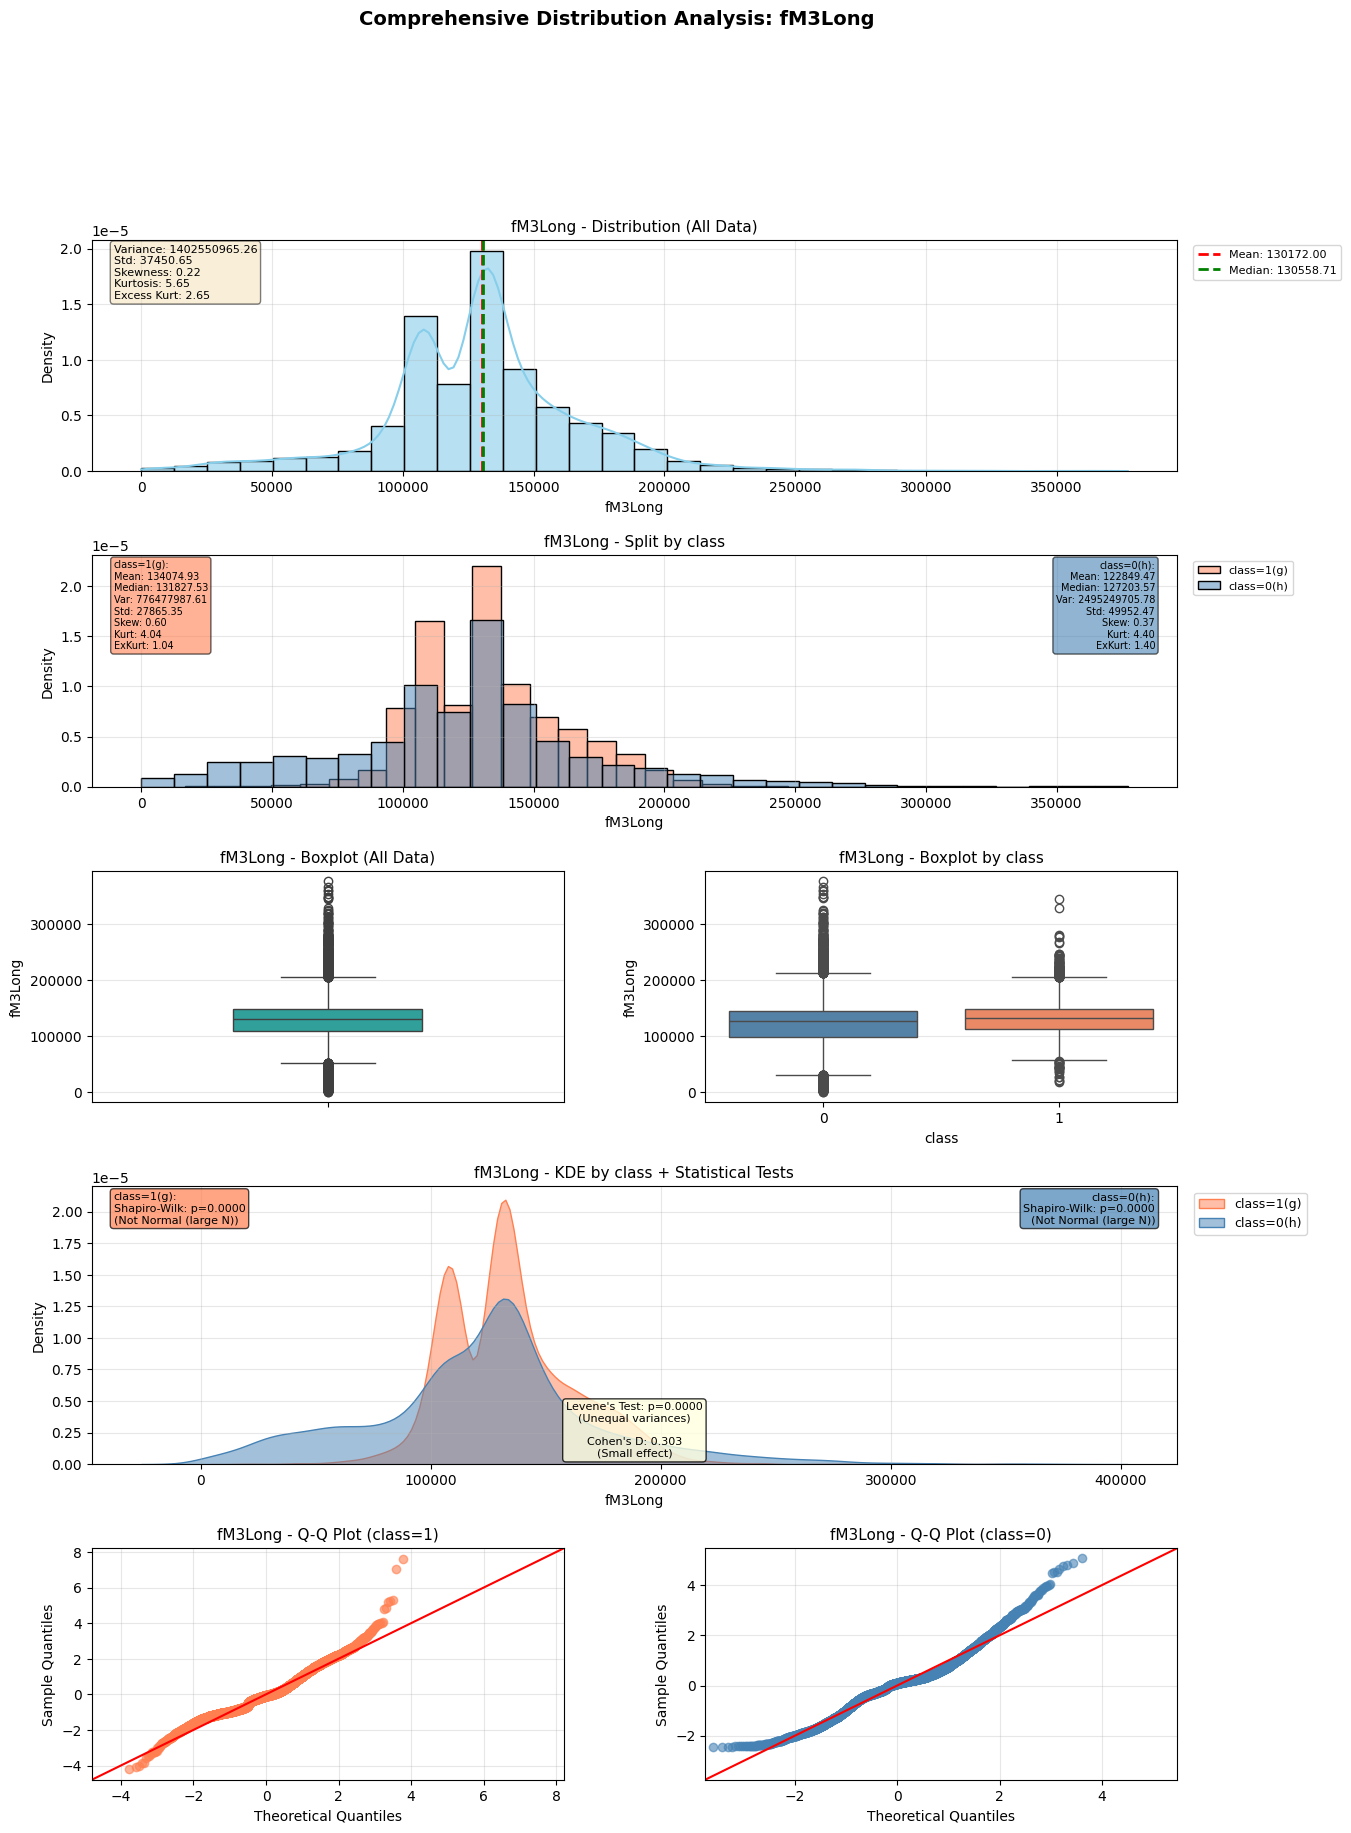

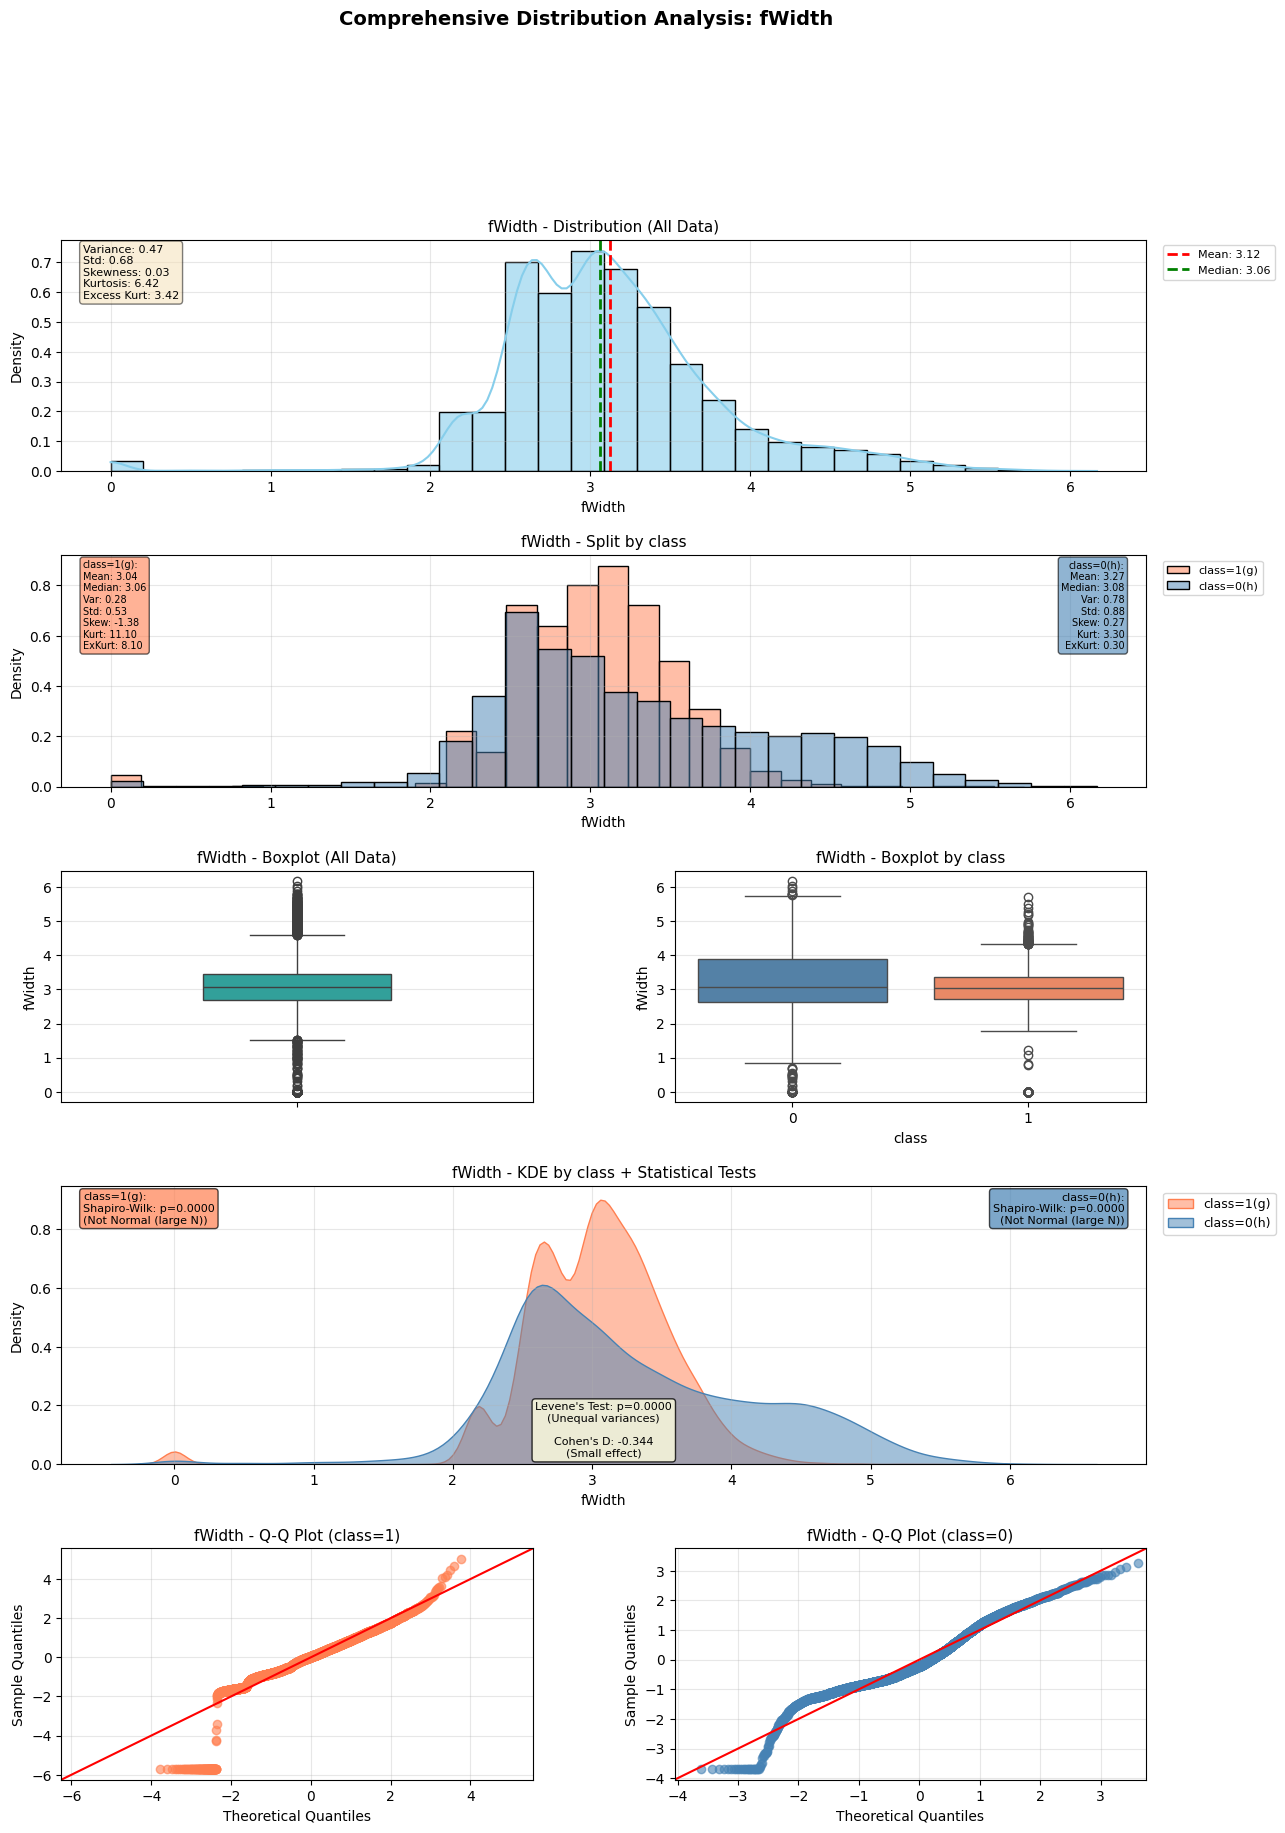

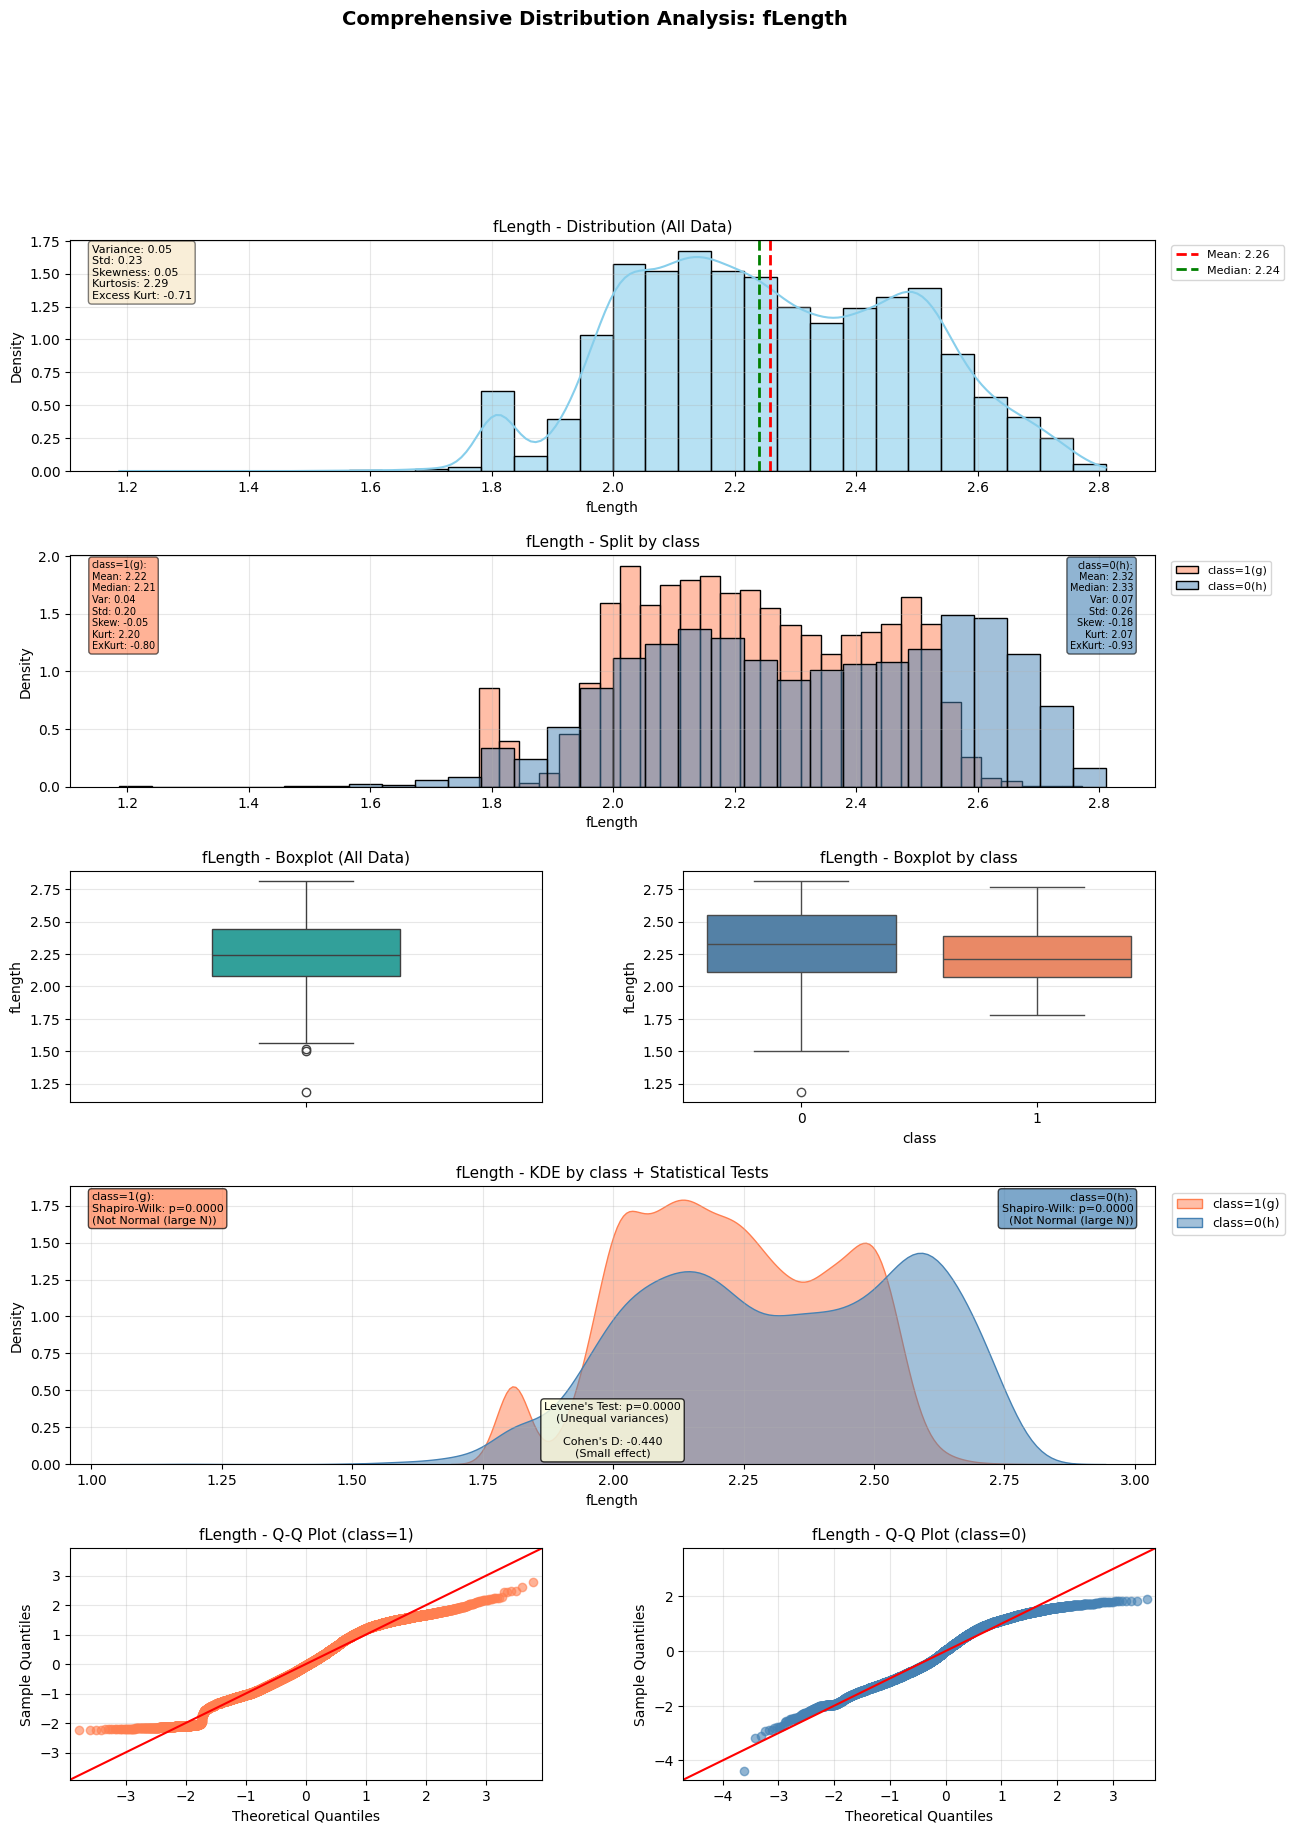

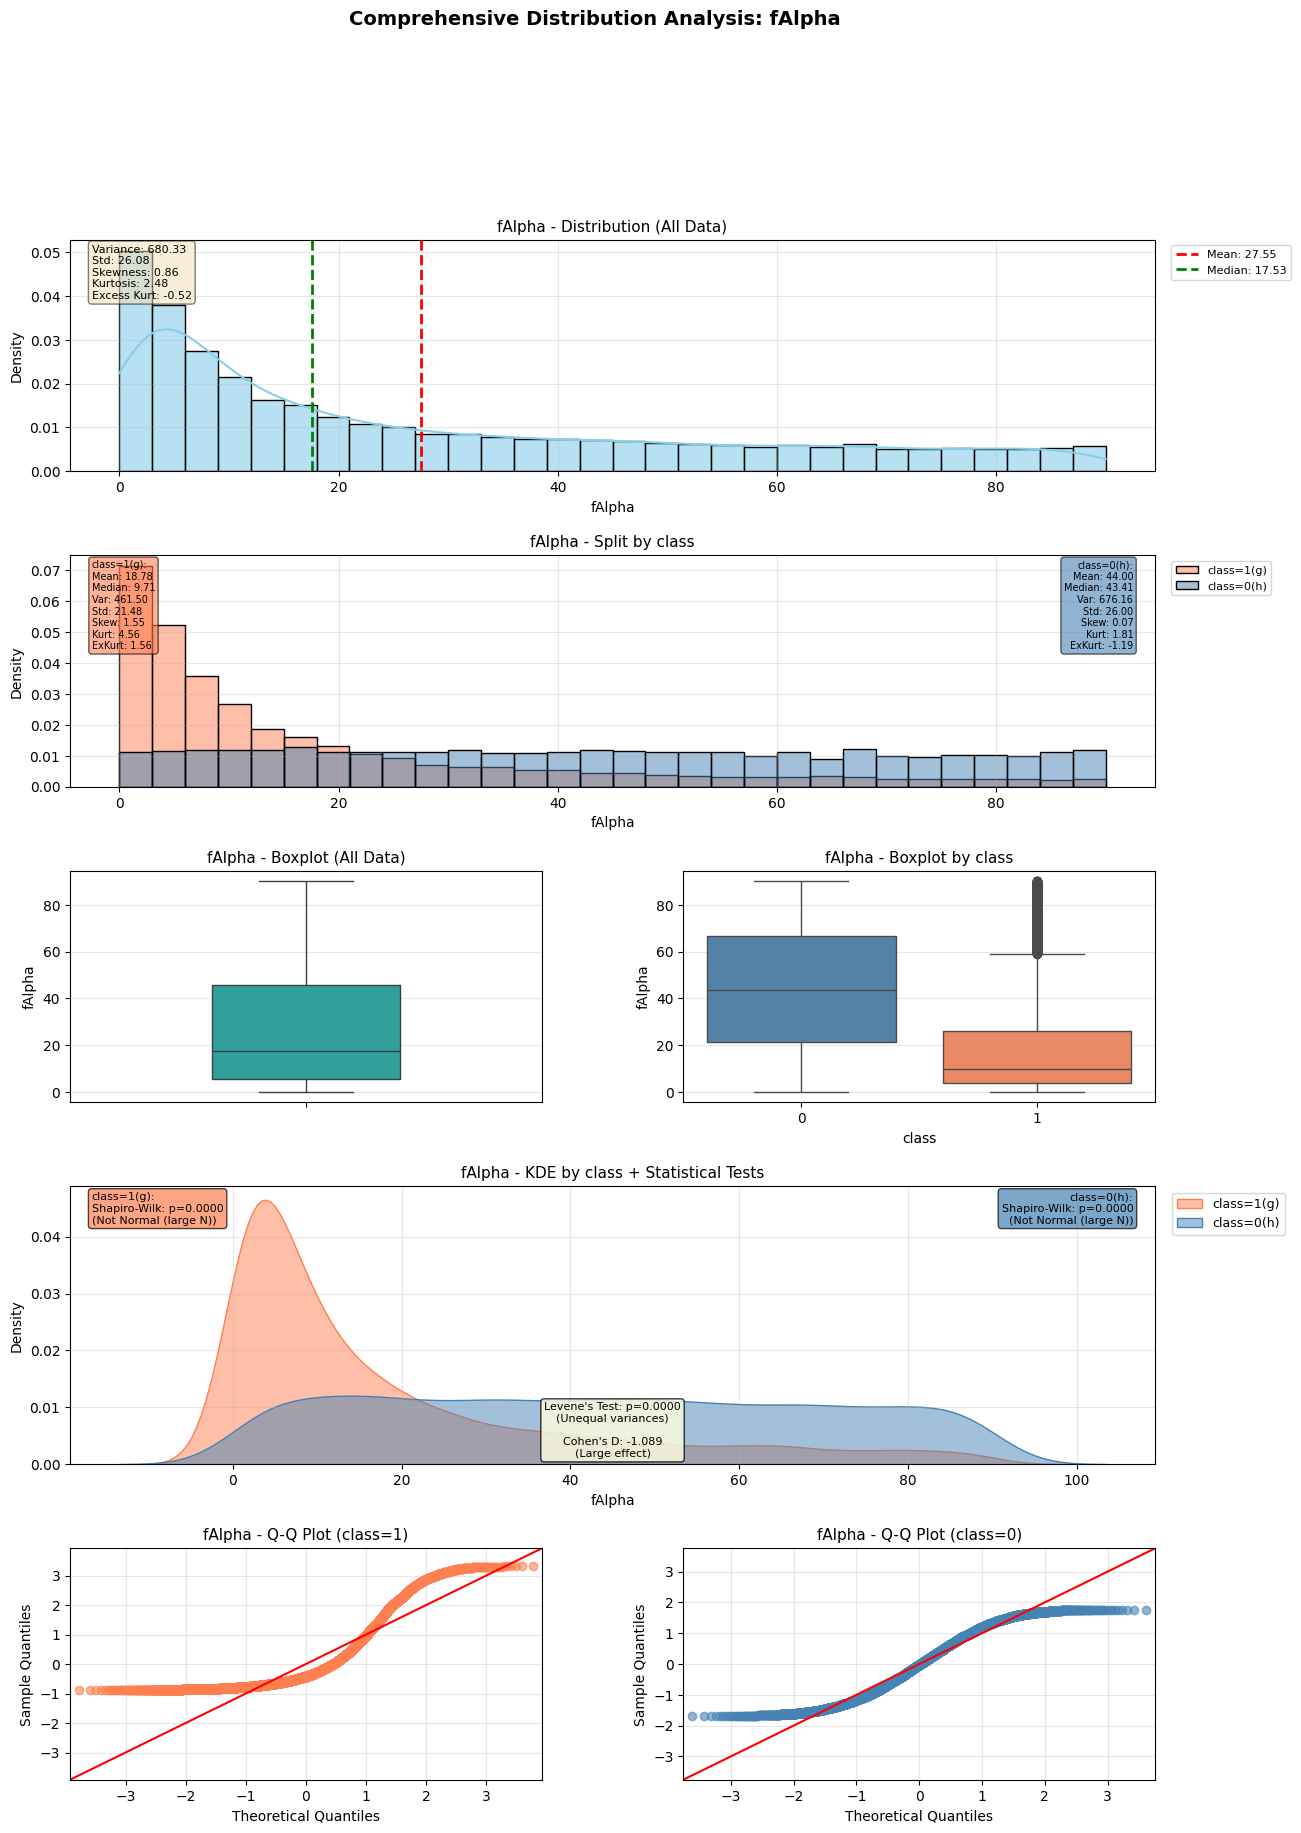

In [26]:
import statsmodels.api as sm

# Sort cols_to_visualize by absolute correlation with 'class' (descending)
correlations = numeric_df.corr()['class'].abs()
cols_to_visualize = correlations.drop('class').sort_values(ascending=True).index.tolist()

for col in cols_to_visualize:
    # Skip non-numeric columns
    if df[col].dtype not in [np.float64, np.int64, np.float32, np.int32]:
        continue
    
    # Prepare data
    data_all = df[col].dropna()
    data_g = df[df['class'] == 1][col].dropna()  # class=1 ('g')
    data_h = df[df['class'] == 0][col].dropna()  # class=0 ('h')
    
    # Skip if insufficient data
    if len(data_g) < 3 or len(data_h) < 3:
        continue
    
    # Create figure with GridSpec (5 rows)
    fig = plt.figure(figsize=(14, 20))
    gs = fig.add_gridspec(5, 2, height_ratios=[1, 1, 1, 1.2, 1], hspace=0.35, wspace=0.3)
    
    # ========== ROW 1: Histogram + KDE + Mean/Median lines (full width) ==========
    ax1 = fig.add_subplot(gs[0, :])
    sns.histplot(data_all, bins=30, kde=True, color='skyblue', ax=ax1, stat='density', alpha=0.6)
    
    # Calculate statistics
    mean_all = data_all.mean()
    median_all = data_all.median()
    variance_all = data_all.var()
    std_all = data_all.std()
    skewness_all = stats.skew(data_all)
    kurt_all = stats.kurtosis(data_all, fisher=False)  # regular kurtosis
    excess_kurt_all = stats.kurtosis(data_all, fisher=True)  # excess kurtosis
    
    # Add vertical lines for mean and median
    ax1.axvline(mean_all, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_all:.2f}')
    ax1.axvline(median_all, color='green', linestyle='--', linewidth=2, label=f'Median: {median_all:.2f}')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=True)
    ax1.set_title(f'{col} - Distribution (All Data)', fontsize=11)
    ax1.set_xlabel(col)
    ax1.set_ylabel('Density')
    ax1.grid(True, alpha=0.3)
    
    # Add text box with statistics
    textstr1 = f'Variance: {variance_all:.2f}\nStd: {std_all:.2f}\nSkewness: {skewness_all:.2f}\nKurtosis: {kurt_all:.2f}\nExcess Kurt: {excess_kurt_all:.2f}'
    ax1.text(0.02, 0.98, textstr1, transform=ax1.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # ========== ROW 2: Overlaid Histograms (class split, full width) ==========
    ax2 = fig.add_subplot(gs[1, :])
    color_0 = 'coral'
    color_1 = 'steelblue'
    
    sns.histplot(data_g, bins=30, color=color_0, alpha=0.5, label=f'class={class_mapping['g']}(g)', ax=ax2, stat='density')
    sns.histplot(data_h, bins=30, color=color_1, alpha=0.5, label=f'class={class_mapping['h']}(h)', ax=ax2, stat='density')
    
    # Calculate statistics for each group
    mean_0, median_0 = data_g.mean(), data_g.median()
    variance_0, std_0 = data_g.var(), data_g.std()
    skewness_0 = stats.skew(data_g)
    kurt_0 = stats.kurtosis(data_g, fisher=False)
    excess_kurt_0 = stats.kurtosis(data_g, fisher=True)
    
    mean_1, median_1 = data_h.mean(), data_h.median()
    variance_1, std_1 = data_h.var(), data_h.std()
    skewness_1 = stats.skew(data_h)
    kurt_1 = stats.kurtosis(data_h, fisher=False)
    excess_kurt_1 = stats.kurtosis(data_h, fisher=True)
    
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=True)
    ax2.set_title(f'{col} - Split by class', fontsize=11)
    ax2.set_xlabel(col)
    ax2.set_ylabel('Density')
    ax2.grid(True, alpha=0.3)
    
    # Text boxes for each group (color-coded)
    textstr_0 = f'class={class_mapping['g']}(g):\nMean: {mean_0:.2f}\nMedian: {median_0:.2f}\nVar: {variance_0:.2f}\nStd: {std_0:.2f}\nSkew: {skewness_0:.2f}\nKurt: {kurt_0:.2f}\nExKurt: {excess_kurt_0:.2f}'
    textstr_1 = f'class={class_mapping['h']}(h):\nMean: {mean_1:.2f}\nMedian: {median_1:.2f}\nVar: {variance_1:.2f}\nStd: {std_1:.2f}\nSkew: {skewness_1:.2f}\nKurt: {kurt_1:.2f}\nExKurt: {excess_kurt_1:.2f}'

    ax2.text(0.02, 0.98, textstr_0, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_0, alpha=0.6))
    ax2.text(0.98, 0.98, textstr_1, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=color_1, alpha=0.6))
    
    # ========== ROW 3, PLOT 1: Boxplot (all data) ==========
    ax3 = fig.add_subplot(gs[2, 0])
    sns.boxplot(y=data_all, color='lightseagreen', ax=ax3, width=0.4)
    ax3.set_title(f'{col} - Boxplot (All Data)', fontsize=11)
    ax3.set_ylabel(col)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========== ROW 3, PLOT 2: Boxplots (split by class) - FIXED ==========
    ax4 = fig.add_subplot(gs[2, 1])
    df_temp = df[[col, 'class']].dropna()
    sns.boxplot(x='class', y=col, data=df_temp, hue='class', palette=[color_1, color_0], ax=ax4, legend=False)
    ax4.set_title(f'{col} - Boxplot by class', fontsize=11)
    ax4.set_xlabel('class')
    ax4.set_ylabel(col)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ========== ROW 4: Wide KDE plot + Statistical tests ==========
    ax5 = fig.add_subplot(gs[3, :])
    sns.kdeplot(data_g, fill=True, color=color_0, label=f'class={class_mapping['g']}(g)', alpha=0.5, ax=ax5)
    sns.kdeplot(data_h, fill=True, color=color_1, label=f'class={class_mapping['h']}(h)', alpha=0.5, ax=ax5)
    ax5.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, frameon=True)
    ax5.set_title(f'{col} - KDE by class + Statistical Tests', fontsize=11)
    ax5.set_xlabel(col)
    ax5.set_ylabel('Density')
    ax5.grid(True, alpha=0.3)
    
    # Statistical tests
    # Shapiro-Wilk for each group
        # Statistical tests
    # Shapiro-Wilk for each group
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='.*For N > 5000.*') # suppress large N warning
        shapiro_0 = stats.shapiro(data_g)
        shapiro_1 = stats.shapiro(data_h)
    
    shapiro_interp_0 = 'Normal' if shapiro_0.pvalue > 0.05 else 'Not Normal'
    shapiro_interp_1 = 'Normal' if shapiro_1.pvalue > 0.05 else 'Not Normal'

    # Add note if sample size is large
    note_0 = " (large N)" if len(data_g) > 5000 else ""
    note_1 = " (large N)" if len(data_h) > 5000 else ""
    
    # Levene's test (variance equality)
    levene_test = stats.levene(data_g, data_h)
    levene_interp = 'Equal variances' if levene_test.pvalue > 0.05 else 'Unequal variances'
    
    # Cohen's D
    cohens_d = cohend(data_g, data_h)
    if abs(cohens_d) < 0.2:
        effect_interp = 'Negligible'
    elif abs(cohens_d) < 0.5:
        effect_interp = 'Small'
    elif abs(cohens_d) < 0.8:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'
    
    # Text boxes for statistical tests
    textstr_tests_0 = f"class={class_mapping['g']}(g):\nShapiro-Wilk: p={shapiro_0.pvalue:.4f}\n({shapiro_interp_0}{note_0})"
    textstr_tests_1 = f"class={class_mapping['h']}(h):\nShapiro-Wilk: p={shapiro_1.pvalue:.4f}\n({shapiro_interp_1}{note_1})"
    textstr_tests_combined = f"Levene's Test: p={levene_test.pvalue:.4f}\n({levene_interp})\n\nCohen's D: {cohens_d:.3f}\n({effect_interp} effect)"
    
    ax5.text(0.02, 0.98, textstr_tests_0, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_0, alpha=0.7))
    ax5.text(0.98, 0.98, textstr_tests_1, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=color_1, alpha=0.7))
    ax5.text(0.5, 0.02, textstr_tests_combined, transform=ax5.transAxes, fontsize=8,
             verticalalignment='bottom', horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # ========== ROW 5, PLOT 1: Q-Q plot for class=1 ==========
    ax6 = fig.add_subplot(gs[4, 0])
    sm.qqplot(data_g, line='45', ax=ax6, alpha=0.6, fit=True, markerfacecolor=color_0, markeredgecolor=color_0)
    ax6.set_title(f'{col} - Q-Q Plot (class=1)', fontsize=11)
    ax6.grid(True, alpha=0.3)
    
    # ========== ROW 5, PLOT 2: Q-Q plot for class=0 ==========
    ax7 = fig.add_subplot(gs[4, 1])
    sm.qqplot(data_h, line='45', ax=ax7, alpha=0.6, fit=True, markerfacecolor=color_1, markeredgecolor=color_1)
    ax7.set_title(f'{col} - Q-Q Plot (class=0)', fontsize=11)
    ax7.grid(True, alpha=0.3)
    
    # Final figure title
    fig.suptitle(f'Comprehensive Distribution Analysis: {col}', fontsize=14, fontweight='bold', y=0.995)
    
    plt.show()
    # print(f"Completed visualization for: {col}\n" + "="*60)

For each numerical feature, we performed a comprehensive statistical and visual analysis to understand its distribution and relationship with the target variable class.

Histograms and KDE plots — examined the overall shape of distributions, including symmetry, skewness, and modality.

Boxplots — detected potential outliers and compared value ranges between the two classes (g and h).

Descriptive statistics (mean, median, variance, skewness, kurtosis) — evaluated central tendency, spread, and shape of each feature’s distribution.

KDE overlap and statistical tests (Shapiro–Wilk, Levene’s test, Cohen’s d) — checked normality, equality of variances, and measured the effect size between the two classes.

Q–Q plots — visually assessed how closely the data followed a normal distribution for each class.

This analysis allowed us to deeply understand how each parameter behaves, how it differs across classes, and which features may be most discriminative for classification.

## **Hypothesis Testing**

**Test 1 - fAlpha**

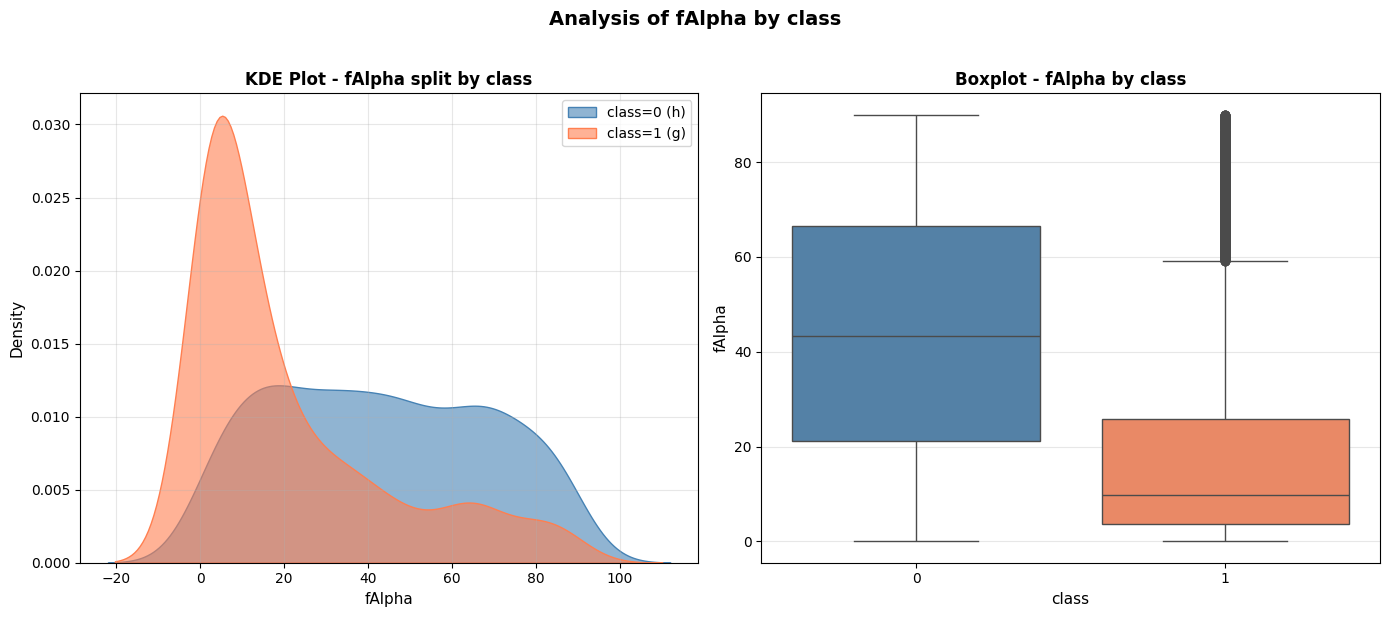

In [27]:
# Data splitting for fAlpha by class
fAlpha_class0 = df[df['class'] == 0]['fAlpha'].dropna()
fAlpha_class1 = df[df['class'] == 1]['fAlpha'].dropna()

fAlpha_class0 = fAlpha_class0.sample(n=500, random_state=42)
fAlpha_class1 = fAlpha_class1.sample(n=500, random_state=42)

# Define colors
color_0 = 'steelblue'
color_1 = 'coral'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fAlpha_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fAlpha_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fAlpha', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fAlpha split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fAlpha', 'class']].dropna()
sns.boxplot(x='class', y='fAlpha', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fAlpha', fontsize=11)
axes[1].set_title('Boxplot - fAlpha by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fAlpha by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [28]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fAlpha_class0)
shapiro_1 = stats.shapiro(fAlpha_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

Shapiro-Wilk test for class=0: W=0.9570, p-value=0.0000
Shapiro-Wilk test for class=1: W=0.7946, p-value=0.0000
class=0: Data do not appear to be normally distributed (reject H0)
class=1: Data do not appear to be normally distributed (reject H0)

At least one sample suggests non-normality. We will use Mann-Whitney U test.


In [29]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fAlpha_class0, fAlpha_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")


Levene's test for equality of variances: W=25.3949, p-value=0.0000
Variances differ (reject H0)


In [30]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fAlpha_class0 has a statistically significantly higher median than group fAlpha_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fAlpha_class0, fAlpha_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fAlpha values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fAlpha values.")


Test results:
  U-statistic: 190031.0000
  p-value: 0.0000

Conclusion:
  p-value (0.0000) < 0.05
  REJECT H0: Group with class=0 has statistically significantly
  higher fAlpha values than group with class=1.


In [31]:
# Calculate Cohen's d for fAlpha between class 0 and 1 groups

c_d = cohend(fAlpha_class1, fAlpha_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fAlpha between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fAlpha_class0), 0.05, None, 1)
print(f"Statistical power of the test for fAlpha between class=0 and class=1: {stat_power:.6f}")

Cohen's d for fAlpha between class=1 and class=0: -0.914
The effect size is large.
Statistical power of the test for fAlpha between class=0 and class=1: 1.000000


**Test 2 - fLength**

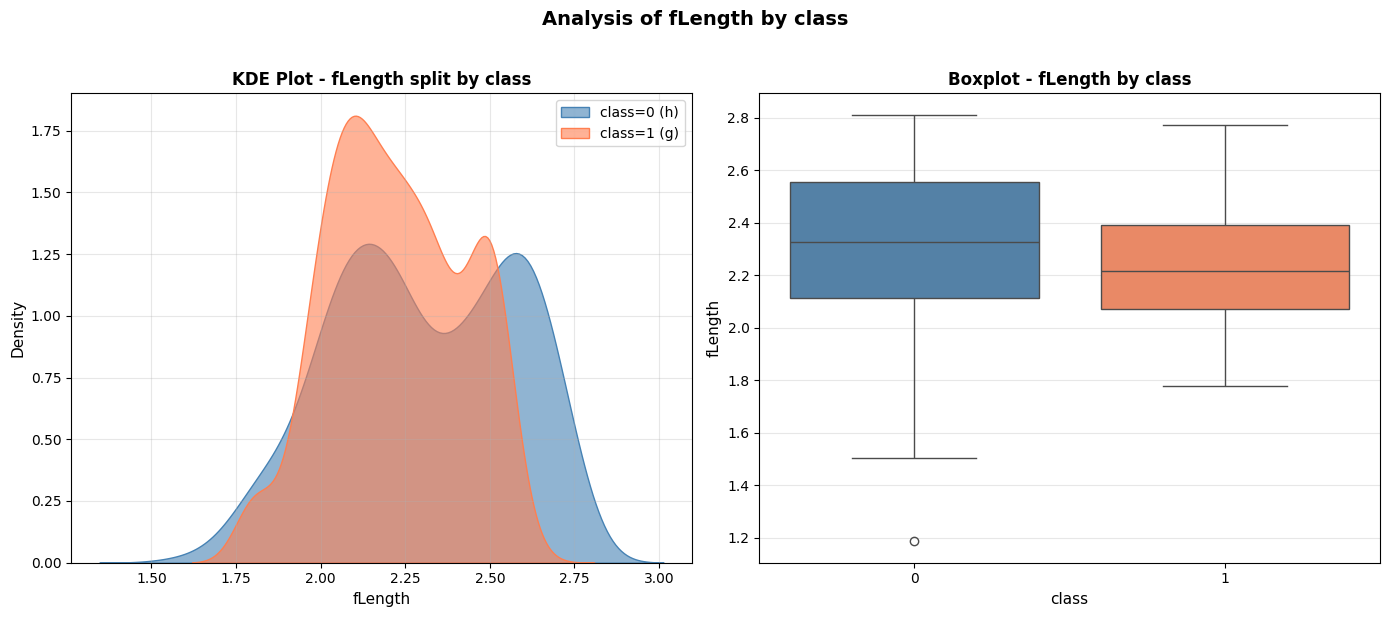

In [32]:
# Data splitting for fLength by class
fLength_class0 = df[df['class'] == 0]['fLength'].dropna()
fLength_class1 = df[df['class'] == 1]['fLength'].dropna()

fLength_class0 = fLength_class0.sample(n=500, random_state=42)
fLength_class1 = fLength_class1.sample(n=500, random_state=42)

# Define colors
color_0 = 'steelblue'
color_1 = 'coral'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fLength_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fLength_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fLength', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fLength split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fLength', 'class']].dropna()
sns.boxplot(x='class', y='fLength', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fLength', fontsize=11)
axes[1].set_title('Boxplot - fLength by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fLength by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [33]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fLength_class0)
shapiro_1 = stats.shapiro(fLength_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

Shapiro-Wilk test for class=0: W=0.9672, p-value=0.0000
Shapiro-Wilk test for class=1: W=0.9725, p-value=0.0000
class=0: Data do not appear to be normally distributed (reject H0)
class=1: Data do not appear to be normally distributed (reject H0)

At least one sample suggests non-normality. We will use Mann-Whitney U test.


In [34]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fLength_class0, fLength_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")


Levene's test for equality of variances: W=71.8225, p-value=0.0000
Variances differ (reject H0)


In [35]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fLength_class0 has a statistically significantly higher median than group fLength_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fLength_class0, fLength_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fLength values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fLength values.")


Test results:
  U-statistic: 149369.0000
  p-value: 0.0000

Conclusion:
  p-value (0.0000) < 0.05
  REJECT H0: Group with class=0 has statistically significantly
  higher fLength values than group with class=1.


In [36]:
# Calculate Cohen's d for fLength between class 0 and 1 groups

c_d = cohend(fLength_class1, fLength_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fLength between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fLength_class0), 0.05, None, 1)
print(f"Statistical power of the test for fLength between class=0 and class=1: {stat_power:.6f}")

Cohen's d for fLength between class=1 and class=0: -0.350
The effect size is medium.
Statistical power of the test for fLength between class=0 and class=1: 0.999825


**Test 3 - fDist**

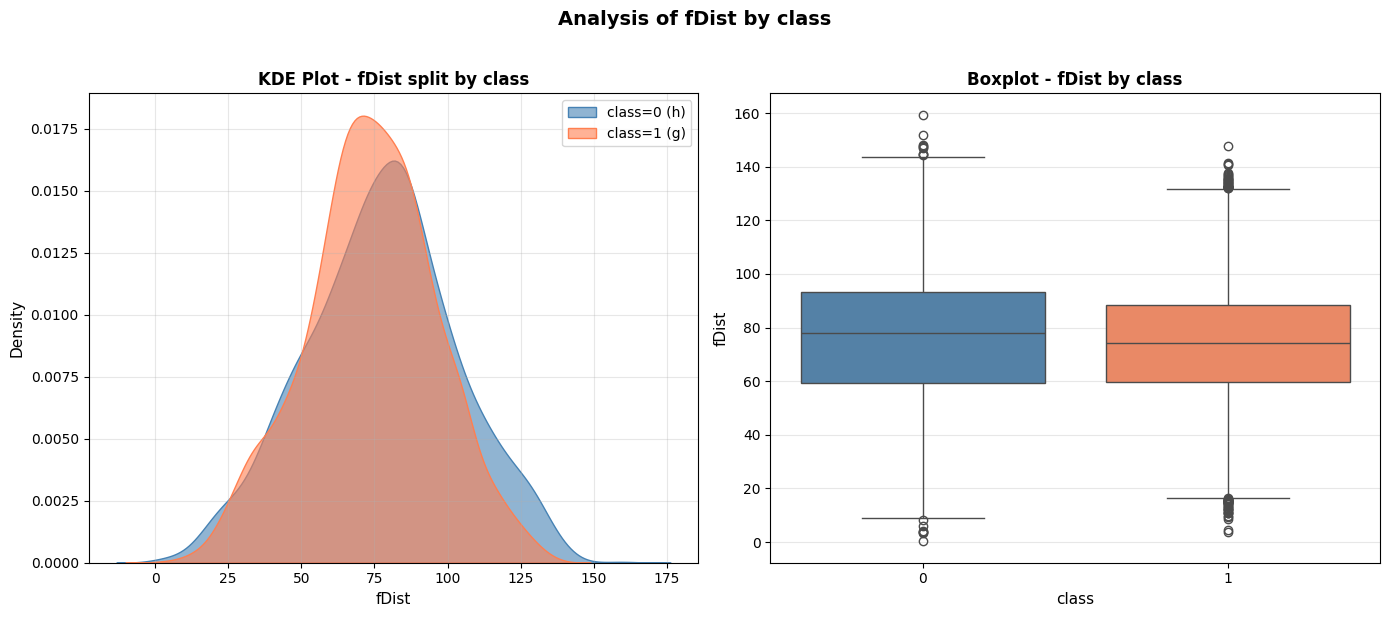

In [37]:
# Data splitting for fDist by class
fDist_class0 = df[df['class'] == 0]['fDist'].dropna()
fDist_class1 = df[df['class'] == 1]['fDist'].dropna()

fDist_class0 = fDist_class0.sample(n=2000, random_state=42)
fDist_class1 = fDist_class1.sample(n=2000, random_state=42)

# Define colors
color_0 = 'steelblue'
color_1 = 'coral'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fDist_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fDist_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fDist', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fDist split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fDist', 'class']].dropna()
sns.boxplot(x='class', y='fDist', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fDist', fontsize=11)
axes[1].set_title('Boxplot - fDist by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fDist by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [38]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fDist_class0)
shapiro_1 = stats.shapiro(fDist_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

Shapiro-Wilk test for class=0: W=0.9969, p-value=0.0005
Shapiro-Wilk test for class=1: W=0.9973, p-value=0.0015
class=0: Data do not appear to be normally distributed (reject H0)
class=1: Data do not appear to be normally distributed (reject H0)

At least one sample suggests non-normality. We will use Mann-Whitney U test.


In [39]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fDist_class0, fDist_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")


Levene's test for equality of variances: W=39.2734, p-value=0.0000
Variances differ (reject H0)


In [40]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fDist_class0 has a statistically significantly higher median than group fDist_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fDist_class0, fDist_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fDist values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fDist values.")


Test results:
  U-statistic: 2168162.0000
  p-value: 0.0000

Conclusion:
  p-value (0.0000) < 0.05
  REJECT H0: Group with class=0 has statistically significantly
  higher fDist values than group with class=1.


In [41]:
# Calculate Cohen's d for fDist between class 0 and 1 groups

c_d = cohend(fDist_class1, fDist_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fDist between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fDist_class0), 0.05, None, 1)
print(f"Statistical power of the test for fDist between class=0 and class=1: {stat_power:.6f}")

Cohen's d for fDist between class=1 and class=0: -0.149
The effect size is small.
Statistical power of the test for fDist between class=0 and class=1: 0.996925


We performed hypothesis testing for three features: fAlpha, fLength, and fDist.
Normality (Shapiro–Wilk) and variance equality (Levene) tests showed that the data are non-normal and have unequal variances.
We applied the Mann–Whitney U test to compare medians between the two classes.
In all three cases, the differences were statistically significant (p < 0.05).
We also calculated Cohen’s d and test power — the effect size ranged from large (fAlpha) to small (fDist), with high reliability of the results.